### Performance comparison vs. sklearn

IREP and RIPPER evaluated on 10 categorical datasets (mostly taken from UCI) repeated 10 times against sklearn's DecisionTreeClassifier and grid-search-optimized RandomForestClassifier as baselines.

Also captured statistics for tree limited to the approximate complexity of IREP
primarily as a curiosity.

Metrics are precision, recall, and complexity (defined as number of conds or nodes).

In [2]:
import pandas as pd
import ruleset as rs
from ruleset.base import Timer
import pickle

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [4]:
def make_rs_dataset(dataset_filename, random_state=42):
    # Load df
    df = pd.read_csv(dataset_filename)
    
    # Split
    train, test = train_test_split(df, test_size=.33, random_state=random_state)
    
    return train, test

In [5]:
def make_ripper(train, class_feat, pos_class, k=2, random_state=42, verbosity=0):
    # Train
    rip_clf = rs.RIPPER(k=k, verbosity=verbosity)
    rip_clf.fit(train, class_feat=class_feat, pos_class=pos_class, 
                n_discretize_bins=5, random_state=random_state)
    return rip_clf

In [6]:
def make_irep(train, class_feat, pos_class, random_state=42, verbosity=0):
    # Train
    irep_clf = rs.IREP(verbosity=verbosity)
    irep_clf.fit(train, class_feat=class_feat, pos_class=pos_class, n_discretize_bins=5, random_state=random_state)
    return irep_clf

In [7]:
def score_ruleset(clf, test):
    X_test = test.drop(clf.class_feat,axis=1)
    y_test = test[class_feat]

    precision = clf.score(X_test, y_test, precision_score)
    recall = clf.score(X_test, y_test, recall_score)
    total_conds = clf.ruleset_.count_conds()
    return precision, recall, total_conds

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def make_tree_dataset(dataset_filename, class_feat, pos_class, random_state=42):
    
    # Load df
    df = pd.read_csv(dataset_filename)
    
    # Get number of classes (for X,y splitting when there are dummies)
    n_classes = len(df[class_feat].unique())
    
    # sklearn's Tree (of all things!) doesn't directly take categorical features.
    # One-hot preprocess the data to make it work.
    le = LabelEncoder()
    df_le = df.apply(le.fit_transform)
    enc = OneHotEncoder(sparse=False)
    enc.fit(df_le)
    df_hot = enc.transform(df_le)
    
    # Split
    train, test = train_test_split(df_hot, test_size=.33, random_state=random_state)
    train_X = train[:,n_classes:]
    train_y = train[:,0]
    test_X = test[:,n_classes:]
    test_y = test[:,0]
    
    return train_X, train_y, test_X, test_y

In [9]:
def make_tree(train_X, train_y, max_depth=None, random_state=42):
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    tree.fit(train_X, train_y)
    return tree

In [10]:
from sklearn.model_selection import GridSearchCV

def make_forest(train_X, train_y, random_state=42):
    forest = RandomForestClassifier(random_state=random_state)#max_depth=max_depth, random_state=random_state)
    n_features = train_X.shape[1]
    grid_params = {
        'n_estimators': [50,100,200],
        'max_depth': [1,3,5,8,10,None],
        'min_samples_leaf': [3,6,10,13,16,20]
    }
    #print(train_X.shape)
    #print(grid_params)
    clf = GridSearchCV(forest, grid_params, cv=5)
    clf.fit(train_X, train_y)
    best_params = clf.best_params_
    print(f'forest best params: {best_params}')
    forest = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                    max_depth=best_params['max_depth'],
                                    min_samples_leaf=best_params['min_samples_leaf'],
                                    random_state=random_state
                                    )
    forest.fit(train_X, train_y)
    
    return forest

In [11]:
def score_tree(tree_clf, test_X, test_y):
    predictions = tree_clf.predict(test_X)
    precision = precision_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    return precision, recall, tree_clf.tree_.node_count

In [12]:
def score_forest(forest_clf, test_X, test_y):
    predictions = forest_clf.predict(test_X)
    precision = precision_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    nodes = sum([est.tree_.node_count for est in forest_clf.estimators_])
    return precision, recall, nodes

In [45]:
import numpy as np
import math

def run_experiment(filename, class_feat, pos_class, k=2, verbosity=0, random_state=42, n_runs=10):
    
    irep_precision_list = []
    irep_recall_list = []
    irep_conds_list = []
    irep_models_list = []
    
    ripper_precision_list = []
    ripper_recall_list = []
    ripper_conds_list = []
    ripper_models_list = []
    
    tree_precision_list = []
    tree_recall_list = []
    tree_nodes_list = []
    tree_models_list = []
    
    forest_precision_list = []
    forest_recall_list = []
    forest_nodes_list = []
    forest_models_list = []
    
    max_tree_precision_list = []
    max_tree_recall_list = []
    max_tree_nodes_list = []
    max_tree_models_list = []
    timer=Timer()
    
    for i in range(n_runs):
        #print(timer.buzz())
        # Set random_state
        random_state = i+random_state
        """
        # Run IREP
        print(f'irep {i+1} of {n_runs}')
        train, test = make_rs_dataset(filename, random_state=random_state)
        irep_clf = make_irep(train, class_feat, pos_class, verbosity=verbosity, random_state=random_state)
        irep_precision, irep_recall, irep_conds = score_ruleset(irep_clf, test)
        if irep_precision != 0:
            irep_precision_list.append(irep_precision)
            irep_recall_list.append(irep_recall)
            irep_conds_list.append(irep_conds)
            irep_models_list.append(irep_clf)
            #print(f'{irep_precision}, {irep_recall}, {irep_conds}')
        else:
            print('warning: precision=0; taking a mulligan on (probably) invalid results')

        # Run RIPPER
        print(f'ripper {i+1} of {n_runs}')
        train, test = make_rs_dataset(filename, random_state=random_state)
        ripper_clf = make_ripper(train, class_feat, pos_class, verbosity=verbosity, random_state=random_state)
        ripper_precision, ripper_recall, ripper_conds = score_ruleset(ripper_clf, test)
        if ripper_precision !=0:
            ripper_precision_list.append(ripper_precision)
            ripper_recall_list.append(ripper_recall)
            ripper_conds_list.append(ripper_conds)
            ripper_models_list.append(ripper_clf) 
            #print(f'{ripper_precision}, {ripper_recall}, {ripper_conds}')
        else:
            print('warning: precision=0; taking a mulligan on (probably) invalid results')
        """
        # Run tree
        print(f'tree {i+1} of {n_runs}')
        tree_train_X, tree_train_y, tree_test_X, tree_test_y = make_tree_dataset(filename, class_feat, pos_class, random_state=random_state)
        tree_clf = make_tree(tree_train_X, tree_train_y, random_state=random_state)
        tree_precision, tree_recall, tree_nodes = score_tree(tree_clf, tree_test_X, tree_test_y)
        if tree_precision !=0:
            tree_precision_list.append(tree_precision)
            tree_recall_list.append(tree_recall)
            tree_nodes_list.append(tree_nodes)
            tree_models_list.append(tree_clf)
            #print(f'{tree_precision}, {tree_recall}, {tree_nodes}')
        else:
            print('warning: precision=0; taking a mulligan on (probably) invalid results')
        """
        # Run max tree
        print(f'max-tree {i+1} of {n_runs}')
        max_depth = max(1,int(math.log2(ripper_conds))) # limit n_nodes to approx n_conds
        max_tree_train_X, max_tree_train_y, max_tree_test_X, max_tree_test_y = make_tree_dataset(filename, class_feat, pos_class, random_state=random_state)
        max_tree_clf = make_tree(max_tree_train_X, max_tree_train_y, max_depth=max_depth, random_state=random_state)
        max_tree_precision, max_tree_recall, max_tree_nodes = score_tree(max_tree_clf, max_tree_test_X, max_tree_test_y)
        if max_tree_precision !=0:
            max_tree_precision_list.append(max_tree_precision)
            max_tree_recall_list.append(max_tree_recall)
            max_tree_nodes_list.append(max_tree_nodes)
            max_tree_models_list.append(max_tree_clf)
            #print(f'{max_tree_precision}, {max_tree_recall}, {max_tree_nodes}')
        else:
            print('warning: precision=0; taking a mulligan on (probably) invalid results')
        """
        # Run forest
        print(f'random forest {i+1} of {n_runs}')
        forest_train_X, forest_train_y, forest_test_X, forest_test_y = make_tree_dataset(filename, class_feat, pos_class, random_state=random_state)
        forest_clf = make_forest(forest_train_X, forest_train_y, random_state=random_state)
        forest_precision, forest_recall, forest_nodes = score_forest(forest_clf, forest_test_X, forest_test_y)
        if forest_precision !=0:
            forest_precision_list.append(forest_precision)
            forest_recall_list.append(forest_recall)
            forest_nodes_list.append(forest_nodes)
            forest_models_list.append(forest_clf)
            #print(f'{tree_precision}, {tree_recall}, {tree_nodes}')
        else:
            print('warning: precision=0; taking a mulligan on (probably) invalid results')
    """
    irep_means = (np.mean(irep_precision_list), np.mean(irep_recall_list), np.mean(irep_conds_list)) if len(irep_precision_list) else 0
    irep_meds = (np.median(irep_precision_list), np.median(irep_recall_list), np.median(irep_conds_list)) if len(irep_precision_list) else 0
    ripper_means = (np.mean(ripper_precision_list), np.mean(ripper_recall_list), np.mean(ripper_conds_list)) if len(ripper_precision_list) else 0
    ripper_meds = (np.median(ripper_precision_list), np.median(ripper_recall_list), np.median(ripper_conds_list)) if len(ripper_precision_list) else 0
    """
    tree_means = (np.mean(tree_precision_list), np.mean(tree_recall_list), np.mean(tree_nodes_list)) if len(tree_precision_list) else 0
    tree_meds = (np.median(tree_precision_list), np.median(tree_recall_list), np.median(tree_nodes_list)) if len(tree_precision_list) else 0
    """
    max_tree_means = (np.mean(max_tree_precision_list), np.mean(max_tree_recall_list), np.mean(max_tree_nodes_list)) if len(max_tree_precision_list) else 0
    max_tree_meds = (np.median(max_tree_precision_list), np.median(max_tree_recall_list), np.median(max_tree_nodes_list)) if len(max_tree_precision_list) else 0
    """
    forest_means = (np.mean(forest_precision_list), np.mean(forest_recall_list), np.mean(forest_nodes_list)) if len(forest_precision_list) else 0
    forest_meds = (np.median(forest_precision_list), np.median(forest_recall_list), np.median(forest_nodes_list)) if len(forest_precision_list) else 0
    
    # Calculate class distribution:
    df = pd.read_csv(filename)
    class_balance = len(df[df[class_feat]==pos_class])/len(df)
    """
    print()
    print(f'class balance: {class_balance}')
    print()
    print(f'means:')
    print(f'ripper {ripper_means}')
    print(f'irep {irep_means}')
    print(f'tree means {tree_means}')
    print(f'max_tree means {max_tree_means}')
    print(f'forest means {forest_means}')
    print()
    print(f'medians')
    print(f'irep medians {irep_meds}')
    print(f'ripper medians {ripper_meds}')
    print(f'tree medians {tree_meds}')
    print(f'forest meds {forest_meds}')
    print(f'max_tree medians {max_tree_meds}')
    
    return {'irep_means':irep_means,
            'irep_meds':irep_meds,
            'irep_models':irep_models_list,

            'ripper_means':ripper_means,
            'ripper_meds':ripper_meds,
            'ripper_models':ripper_models_list,
    """
    return {
            'tree_means':tree_means,
            'tree_meds':tree_meds,
            'tree_models':tree_models_list,
    """
            'max_tree_means':max_tree_means,
            'max_tree_meds':max_tree_meds,
            'max_tree_models':max_tree_models_list,
    """
            'forest_means':forest_means,
            'forest_meds':forest_meds,
            'forest_models':forest_models_list
    }
    """      
            'n':n_runs,
            'class_balance':class_balance
           }
    """
    
   

In [14]:
datasets_path = '../datasets/'
random_state = 42

In [83]:
# Set up
dataset = 'breast-cancer.csv'
filename = datasets_path + dataset
class_feat = 'Recurrence'
pos_class = 'recurrence-events'
k=2
n_runs=10

timer = Timer()
breast_cancer_results = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
timer.stop()
pickle.dump(breast_cancer_results,open(filename.replace('.csv','.pkl'),'wb'))
breast_cancer_results

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
irep 7 of 10
ripper 7 of 10
tree 7 of 10
max-tree 7 of 10
irep 8 of 10
ripper 8 of 10
tree 8 of 10
max-tree 8 of 10
irep 9 of 10
ripper 9 of 10
tree 9 of 10
max-tree 9 of 10
irep 10 of 10
ripper 10 of 10
tree 10 of 10
max-tree 10 of 10

means:
ripper (0.6359574571769693, 0.28957228823848735, 3.7)
irep (0.5756503800858639, 0.31708747162271006, 2.4)
tree means (0.7675098970296164, 0.7343734657077312, 127.6)
max_tree means (0.775415667153092, 0.883709599636459, 6.2)

medians
irep medians (0.5, 0.3220046082949309, 2.0)
ripper medians (0.6181818181818182, 0.2596153846153846, 4.0)
tree medians (0.7583333333333333, 0.7503785420722475, 127.0)
max_tree 

{'irep_means': (0.6359574571769693, 0.28957228823848735, 3.7),
 'irep_meds': (0.6181818181818182, 0.2596153846153846, 4.0),
 'irep_models': [<IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>,
  <IREP object with fit ruleset>],
 'max_tree_means': (0.775415667153092, 0.883709599636459, 6.2),
 'max_tree_meds': (0.7739648326715826, 0.9095238095238095, 7.0),
 'max_tree_models': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best'),
  DecisionTree

In [20]:
# Add random forest

dataset = 'breast-cancer.csv'
filename = datasets_path + dataset
class_feat = 'Recurrence'
pos_class = 'recurrence-events'
k=2
n_runs=10
verbosity=0

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest best params: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 50}
random forest 2 of 10
forest best params: {'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 50}
random forest 3 of 10
forest best params: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 4 of 10
forest best params: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 5 of 10
forest best params: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 6 of 10
forest best params: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 7 of 10
forest best params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 8 of 10
forest best params: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 9 of 10
forest best params: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 10 of 10
forest best params: {'max_depth': 5, 'min_samples_le

In [39]:
# Set up

# Merge good, vgood
dataset = 'car.csv'
filename = datasets_path + dataset
df = pd.read_csv(filename)
df['mod_class'] = df['class'].map(lambda x: 'good-vgood' if x in {'good','vgood'} else x)
#df.to_csv(datasets_path + 'car_mod.csv')

k=2
verbosity=0
n_runs=10

dataset = 'car_mod.csv'
filename = datasets_path + dataset
class_feat = 'mod_class'
pos_class = 'good-vgood'
car_results = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=42, n_runs=n_runs)
pickle.dump(car_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
irep 7 of 10
ripper 7 of 10
tree 7 of 10
max-tree 7 of 10
irep 8 of 10
ripper 8 of 10
tree 8 of 10
max-tree 8 of 10
irep 9 of 10
ripper 9 of 10
tree 9 of 10
max-tree 9 of 10
irep 10 of 10
ripper 10 of 10
tree 10 of 10
max-tree 10 of 10

class balance: 0.0775462962962963

means:
ripper (0.6578135727811323, 0.7817602017667922, 70.1)
irep (0.6869360799875506, 0.40549524833785633, 14.4)
tree means (0.372499976001423, 0.24426395328504286, 606.4)
max_tree means (0.5888716139491696, 0.23457488871972113, 28.2)

medians
irep medians (0.6810924369747899, 0.4476744186046512, 12.5)
ripper medians (0.6475155279503106, 0.7866531850353893, 67.5)
tree medians 

In [213]:
# Car Forest

k=2
verbosity=0
n_runs=10

dataset = 'car_mod.csv'
filename = datasets_path + dataset
class_feat = 'mod_class'
pos_class = 'good-vgood'

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 2 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 100}
random forest 3 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 4 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 5 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 6 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 7 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 8 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 9 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 10 of 10
forest

In [21]:
# Set up
dataset = 'connect-4.csv'
filename = datasets_path + dataset
class_feat = 'class'
pos_class = 'win'
verbosity=2
n_runs=10

connect4_results = run_experiment(filename, class_feat, pos_class, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(connect4_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
pos_growset 19976 pos_pruneset 9839
neg_growset 10350 neg_pruneset 5098
growing rule
[]
gain 1577 [a1=o]
negs remaining 2108
gain 468 [a1=o^d1=x]
negs remaining 368
gain 101 [a1=o^d1=x^d2=b]
negs remaining 106
gain 31.5 [a1=o^d1=x^d2=b^c2=b]
negs remaining 44
gain 16.7 [a1=o^d1=x^d2=b^c2=b^b1=o]
negs remaining 8
gain 2.6 [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b]
negs remaining 2
gain 1.8 [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]
negs remaining 0
grew rule: [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]
prune value of [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 0.34
prune value of [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b]: 0.35
prune value of [a1=o^d1=x^d2=b^c2=b^b1=o]: 0.35
prune value of [a1=o^d1=x^d2=b^c2=b]: 0.37
prune value of [a1=o^d1=x^d2=b]: 0.38
prune value of [a1=o^d1=x]: 0.41
prune value of [a1=o]: 0.5
pruned rule: [a1=o]
updated ruleset: [a1=o]

examples remaining: 19345 pos, 12274 neg

pos_growset 12961 pos_pruneset 6384
neg_growset 8223 neg_pruneset 4051
growing rule
[]
gain 1198 [g1=o]
negs remainin

gain 54.9 [d1=b^c1=b]
negs remaining 54
gain 17.2 [d1=b^c1=b^b4=x]
negs remaining 2
gain 1.5 [d1=b^c1=b^b4=x^b5=o]
negs remaining 0
grew rule: [d1=b^c1=b^b4=x^b5=o]
prune value of [d1=b^c1=b^b4=x^b5=o]: 0.74
prune value of [d1=b^c1=b^b4=x]: 0.74
prune value of [d1=b^c1=b]: 0.74
prune value of [d1=b]: 0.66
pruned rule: [d1=b^c1=b^b4=x]
updated ruleset: ...[c1=o^a1=b^c3=x] V [d1=b^c1=b^b4=x]

examples remaining: 1031 pos, 2904 neg

pos_growset 690 pos_pruneset 341
neg_growset 1945 neg_pruneset 959
growing rule
[]
gain 104 [g1=b]
negs remaining 1108
gain 62.2 [g1=b^c1=o]
negs remaining 298
gain 29.3 [g1=b^c1=o^d1=o]
negs remaining 137
gain 23.9 [g1=b^c1=o^d1=o^a1=b]
negs remaining 30
gain 14.1 [g1=b^c1=o^d1=o^a1=b^c3=b]
negs remaining 14
gain 2.9 [g1=b^c1=o^d1=o^a1=b^c3=b^d3=x]
negs remaining 0
grew rule: [g1=b^c1=o^d1=o^a1=b^c3=b^d3=x]
prune value of [g1=b^c1=o^d1=o^a1=b^c3=b^d3=x]: 0.74
prune value of [g1=b^c1=o^d1=o^a1=b^c3=b]: 0.75
prune value of [g1=b^c1=o^d1=o^a1=b]: 0.75
prune valu

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
rule dl: 18.7
updated theory dl: 39.6
exceptions: 41682
total dl: 41721
mdl 41833 (diff -112 <= 64)
examples remaining: 29430 pos, 15447 neg

pos_growset 19718 pos_pruneset 9712
neg_growset 10349 neg_pruneset 5098
growing rule
[]
gain 1539 [a1=o]
negs remaining 2068
gain 405 [a1=o^b1=o]
negs remaining 195
gain 54.3 [a1=o^b1=o^g1=b]
negs remaining 61
gain 20.7 [a1=o^b1=o^g1=b^a2=b]
negs remaining 14
gain 5 [a1=o^b1=o^g1=b^a2=b^c2=b]
negs remaining 3
gain 3.9 [a1=o^b1=o^g1=b^a2=b^c2=b^d5=b]
negs remaining 0
grew rule: [a1=o^b1=o^g1=b^a2=b^c2=b^d5=b]
prune value of [a1=o^b1=o^g1=b^a2=b^c2=b^d5=b]: 0.97
prune value of [a1=o^b1=o^g1=b^a2=b^c2=b]: 0.97
prune value of [a1=o^b1=o^g1=b^a2=b]: 0.92
prune value of [a1=o^b1=o^g1=b]: 0.83
prune value of [a1=o^b1=o]: 0.77
prune value of [a1=o]: 0.5
pruned rule: [a1=o^b1=o^g1=b^a2=b^c2=b]
updated ruleset: ..

gain 3.1 [g1=o^b2=x^a1=o^b3=b^d2=b]
negs remaining 2
gain 1.3 [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b]
negs remaining 1
gain 1.3 [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b]
negs remaining 0
grew rule: [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b]
prune value of [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b]: 0.97
prune value of [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b]: 0.93
prune value of [g1=o^b2=x^a1=o^b3=b^d2=b]: 0.93
prune value of [g1=o^b2=x^a1=o^b3=b]: 0.94
prune value of [g1=o^b2=x^a1=o]: 0.89
prune value of [g1=o^b2=x]: 0.69
prune value of [g1=o]: 0.47
pruned rule unchanged
updated ruleset: ...[a1=o^c2=x^c3=b^d3=b^e1=o^e4=b] V [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b]

rule theory bits| [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 3594 fp 15 fn 26236: exceptions_bits 39754
rule dl: 20.9
updated theory dl: 177
exceptions: 39754
total dl: 39931
mdl 40065 (diff -133.46 <= 64)
examples remaining: 26236 pos,

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 4730 fp 31 fn 25116: exceptions_bits 39100
rule dl: 13.8
updated theory dl: 293
exceptions: 39100
total dl: 39393
mdl 39483 (diff -90.19 <= 64)
examples remaining: 25116 pos, 15417 neg

pos_growset 16827 pos_pruneset 8289
neg_growset 10329 neg_pruneset 5088
growing rule
[]
gain 992 [a1=o]
negs remaining 2100
gain 241 [a1=o^d1=x]
negs remaining 359
gain 92.7 [a1=o^d1=x^d2=b]
negs remaining 102
gain 15.9 [a1=o^d1=x^d2=b^b1=o]
negs remaining 18
gain 10.6 [a1=o^d1=x^d2=b^b1=o^c1=o]
negs remaining 0
grew rule: [a1=o^d1=x^d2=b^b1=o^c1=o]
prune value of [a1=o^d1=x^d2=b^b1=o^c1=o]: 1
prune value of [a1=o^d1=x^d2=b^b1=o]: 0.7
prune value of [a1=o^d1=x^d2=b]: 0.73
prune value of [a1=o^d1=x]: 0.6
prune value of [a1=o]: 0.4
pruned rule unchanged
updated ruleset: ...[g1=o^e1=o^c1=o^a1=b] V [a1=o^d1=x^d2=b^b1=o^c1=o]

rule theory bits| [a1=o^d1=x^d2=b^b1=o^c1=o] k 5 n 126 pr 0.04: 16.3 bits
except

gain 917 [g1=o]
negs remaining 1939
gain 180 [g1=o^g2=o]
negs remaining 165
gain 38.5 [g1=o^g2=o^b1=o]
negs remaining 9
gain 4.9 [g1=o^g2=o^b1=o^d1=x]
negs remaining 1
gain 0.99 [g1=o^g2=o^b1=o^d1=x^e1=b]
negs remaining 0
grew rule: [g1=o^g2=o^b1=o^d1=x^e1=b]
prune value of [g1=o^g2=o^b1=o^d1=x^e1=b]: 0.94
prune value of [g1=o^g2=o^b1=o^d1=x]: 0.95
prune value of [g1=o^g2=o^b1=o]: 0.89
prune value of [g1=o^g2=o]: 0.61
prune value of [g1=o]: 0.39
pruned rule: [g1=o^g2=o^b1=o^d1=x]
updated ruleset: ...[a1=o^d1=x^d2=b^a3=o^c2=b] V [g1=o^g2=o^b1=o^d1=x]

rule theory bits| [g1=o^g2=o^b1=o^d1=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 5652 fp 45 fn 24208: exceptions_bits 38554
rule dl: 13.8
updated theory dl: 430
exceptions: 38554
total dl: 38984
mdl 39050 (diff -66.37 <= 64)
examples remaining: 24208 pos, 15403 neg

pos_growset 16219 pos_pruneset 7989
neg_growset 10320 neg_pruneset 5083
growing rule

gain 32.8 [g1=o^e1=o^g2=o]
negs remaining 7
gain 3.5 [g1=o^e1=o^g2=o^g4=b]
negs remaining 3
gain 1.8 [g1=o^e1=o^g2=o^g4=b^f1=b]
negs remaining 1
gain 1.1 [g1=o^e1=o^g2=o^g4=b^f1=b^a3=b]
negs remaining 0
grew rule: [g1=o^e1=o^g2=o^g4=b^f1=b^a3=b]
prune value of [g1=o^e1=o^g2=o^g4=b^f1=b^a3=b]: 1
prune value of [g1=o^e1=o^g2=o^g4=b^f1=b]: 1
prune value of [g1=o^e1=o^g2=o^g4=b]: 0.9
prune value of [g1=o^e1=o^g2=o]: 0.89
prune value of [g1=o^e1=o]: 0.5
prune value of [g1=o]: 0.36
pruned rule: [g1=o^e1=o^g2=o^g4=b^f1=b]
updated ruleset: ...[d1=x^d3=x^d2=x] V [g1=o^e1=o^g2=o^g4=b^f1=b]

rule theory bits| [g1=o^e1=o^g2=o^g4=b^f1=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 6791 fp 68 fn 23092: exceptions_bits 37886
rule dl: 16.3
updated theory dl: 550
exceptions: 37886
total dl: 38436
mdl 38496 (diff -59.78 <= 64)
examples remaining: 23092 pos, 15380 neg

pos_growset 15471 pos_pruneset 7621
neg_growset 

gain 2.7 [g1=o^b2=x^g2=o^c1=b^a1=b]
negs remaining 0
grew rule: [g1=o^b2=x^g2=o^c1=b^a1=b]
prune value of [g1=o^b2=x^g2=o^c1=b^a1=b]: 0.8
prune value of [g1=o^b2=x^g2=o^c1=b]: 0.89
prune value of [g1=o^b2=x^g2=o]: 0.75
prune value of [g1=o^b2=x]: 0.57
prune value of [g1=o]: 0.33
pruned rule: [g1=o^b2=x^g2=o^c1=b]
updated ruleset: ...[g1=o^b2=x^b3=x^b4=o^a1=x] V [g1=o^b2=x^g2=o^c1=b]

rule theory bits| [g1=o^b2=x^g2=o^c1=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 7707 fp 88 fn 22196: exceptions_bits 37335
rule dl: 13.8
updated theory dl: 671
exceptions: 37335
total dl: 38006
mdl 38033 (diff -26.97 <= 64)
examples remaining: 22196 pos, 15360 neg

pos_growset 14871 pos_pruneset 7325
neg_growset 10291 neg_pruneset 5069
growing rule
[]
gain 719 [c3=x]
negs remaining 628
gain 176 [c3=x^c2=x]
negs remaining 40
gain 30 [c3=x^c2=x^d3=b]
negs remaining 16
gain 6.1 [c3=x^c2=x^d3=b^f2=b]
negs remaining 9
g

gain 167 [a1=o^d1=x]
negs remaining 336
gain 55.5 [a1=o^d1=x^d2=b]
negs remaining 90
gain 18.3 [a1=o^d1=x^d2=b^c2=b]
negs remaining 40
gain 10.3 [a1=o^d1=x^d2=b^c2=b^e1=b]
negs remaining 17
gain 6.5 [a1=o^d1=x^d2=b^c2=b^e1=b^f1=o]
negs remaining 0
grew rule: [a1=o^d1=x^d2=b^c2=b^e1=b^f1=o]
prune value of [a1=o^d1=x^d2=b^c2=b^e1=b^f1=o]: 0.57
prune value of [a1=o^d1=x^d2=b^c2=b^e1=b]: 0.66
prune value of [a1=o^d1=x^d2=b^c2=b]: 0.65
prune value of [a1=o^d1=x^d2=b]: 0.59
prune value of [a1=o^d1=x]: 0.43
prune value of [a1=o]: 0.28
pruned rule: [a1=o^d1=x^d2=b^c2=b^e1=b]
updated ruleset: ...[a1=o^b1=b^g1=o^a2=b^c1=x^g2=b] V [a1=o^d1=x^d2=b^c2=b^e1=b]

rule theory bits| [a1=o^d1=x^d2=b^c2=b^e1=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 8987 fp 132 fn 20960: exceptions_bits 36620
rule dl: 16.3
updated theory dl: 804
exceptions: 36620
total dl: 37424
mdl 37417 (diff 7 <= 64)
examples remaining: 20960 

gain 65.2 [d1=x^d2=b^b1=o^c2=b]
negs remaining 67
gain 17.3 [d1=x^d2=b^b1=o^c2=b^a2=o]
negs remaining 6
gain 2.4 [d1=x^d2=b^b1=o^c2=b^a2=o^c1=o]
negs remaining 0
grew rule: [d1=x^d2=b^b1=o^c2=b^a2=o^c1=o]
prune value of [d1=x^d2=b^b1=o^c2=b^a2=o^c1=o]: 1
prune value of [d1=x^d2=b^b1=o^c2=b^a2=o]: 0.83
prune value of [d1=x^d2=b^b1=o^c2=b]: 0.67
prune value of [d1=x^d2=b^b1=o]: 0.53
prune value of [d1=x^d2=b]: 0.39
prune value of [d1=x]: 0.28
pruned rule unchanged
updated ruleset: ...[g1=o^f1=o^b1=x^g2=b^a1=b^f3=x] V [d1=x^d2=b^b1=o^c2=b^a2=o^c1=o]

rule theory bits| [d1=x^d2=b^b1=o^c2=b^a2=o^c1=o] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 9746 fp 149 fn 20218: exceptions_bits 36123
rule dl: 18.7
updated theory dl: 926
exceptions: 36123
total dl: 37049
mdl 37064 (diff -14.65 <= 64)
examples remaining: 20218 pos, 15299 neg

pos_growset 13546 pos_pruneset 6672
neg_growset 10250 neg_pruneset 5049
grow

gain 546 [a1=o]
negs remaining 2097
gain 154 [a1=o^b2=x]
negs remaining 225
gain 36.8 [a1=o^b2=x^b3=b]
negs remaining 103
gain 29.2 [a1=o^b2=x^b3=b^d2=b]
negs remaining 51
gain 11.6 [a1=o^b2=x^b3=b^d2=b^c1=o]
negs remaining 8
gain 2.9 [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o]
negs remaining 1
gain 1.2 [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b]
negs remaining 0
grew rule: [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b]
prune value of [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b]: 0.8
prune value of [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o]: 0.73
prune value of [a1=o^b2=x^b3=b^d2=b^c1=o]: 0.78
prune value of [a1=o^b2=x^b3=b^d2=b]: 0.64
prune value of [a1=o^b2=x^b3=b]: 0.63
prune value of [a1=o^b2=x]: 0.48
prune value of [a1=o]: 0.26
pruned rule unchanged
updated ruleset: ...[d1=x^d2=b^b1=o^c1=o^a1=b^g1=x^e1=b] V [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b]

rule theory bits| [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 

gain 2.8 [c3=x^b2=x^b3=b^f3=b]
negs remaining 1
gain 1.4 [c3=x^b2=x^b3=b^f3=b^d3=b]
negs remaining 0
grew rule: [c3=x^b2=x^b3=b^f3=b^d3=b]
prune value of [c3=x^b2=x^b3=b^f3=b^d3=b]: 0.97
prune value of [c3=x^b2=x^b3=b^f3=b]: 0.97
prune value of [c3=x^b2=x^b3=b]: 0.97
prune value of [c3=x^b2=x]: 0.86
prune value of [c3=x]: 0.38
pruned rule: [c3=x^b2=x^b3=b]
updated ruleset: ...[a1=o^a2=o^f2=x^c2=b^f3=b^d2=b] V [c3=x^b2=x^b3=b]

rule theory bits| [c3=x^b2=x^b3=b] k 3 n 126 pr 0.02: 11 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 11737 fp 230 fn 18308: exceptions_bits 34941
rule dl: 11
updated theory dl: 1163
exceptions: 34941
total dl: 36103
mdl 36232 (diff -128.14 <= 64)
examples remaining: 18308 pos, 15218 neg

pos_growset 12266 pos_pruneset 6042
neg_growset 10196 neg_pruneset 5022
growing rule
[]
gain 572 [a1=o]
negs remaining 2009
gain 136 [a1=o^c2=x]
negs remaining 269
gain 125 [a1=o^c2=x^c3=b]
negs remaining 43
gain 29

gain 97 [a1=b^f1=o^e1=o]
negs remaining 119
gain 29.1 [a1=b^f1=o^e1=o^c1=x]
negs remaining 58
gain 10.8 [a1=b^f1=o^e1=o^c1=x^d1=o]
negs remaining 2
gain 1.6 [a1=b^f1=o^e1=o^c1=x^d1=o^g2=b]
negs remaining 0
grew rule: [a1=b^f1=o^e1=o^c1=x^d1=o^g2=b]
prune value of [a1=b^f1=o^e1=o^c1=x^d1=o^g2=b]: 1
prune value of [a1=b^f1=o^e1=o^c1=x^d1=o]: 0.83
prune value of [a1=b^f1=o^e1=o^c1=x]: 0.45
prune value of [a1=b^f1=o^e1=o]: 0.37
prune value of [a1=b^f1=o]: 0.22
prune value of [a1=b]: 0.12
pruned rule unchanged
updated ruleset: ...[c3=x^c2=x^d3=b^g1=b] V [a1=b^f1=o^e1=o^c1=x^d1=o^g2=b]

rule theory bits| [a1=b^f1=o^e1=o^c1=x^d1=o^g2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 12917 fp 268 fn 17166: exceptions_bits 34126
rule dl: 18.7
updated theory dl: 1286
exceptions: 34126
total dl: 35411
mdl 35431 (diff -19.27 <= 64)
examples remaining: 17166 pos, 15180 neg

pos_growset 11501 pos_pruneset 5665
neg_

gain 6.2 [g1=o^f1=o^a1=b^b1=b^c4=b]
negs remaining 7
gain 2.3 [g1=o^f1=o^a1=b^b1=b^c4=b^d2=o]
negs remaining 0
grew rule: [g1=o^f1=o^a1=b^b1=b^c4=b^d2=o]
prune value of [g1=o^f1=o^a1=b^b1=b^c4=b^d2=o]: 1
prune value of [g1=o^f1=o^a1=b^b1=b^c4=b]: 0.43
prune value of [g1=o^f1=o^a1=b^b1=b]: 0.47
prune value of [g1=o^f1=o^a1=b]: 0.42
prune value of [g1=o^f1=o]: 0.35
prune value of [g1=o]: 0.18
pruned rule unchanged
updated ruleset: ...[d1=x^c1=b^a1=b^e1=b^b1=x] V [g1=o^f1=o^a1=b^b1=b^c4=b^d2=o]

rule theory bits| [g1=o^f1=o^a1=b^b1=b^c4=b^d2=o] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13491 fp 282 fn 16606: exceptions_bits 33688
rule dl: 18.7
updated theory dl: 1409
exceptions: 33688
total dl: 35097
mdl 35104 (diff -6.65 <= 64)
examples remaining: 16606 pos, 15166 neg

pos_growset 11126 pos_pruneset 5480
neg_growset 10161 neg_pruneset 5005
growing rule
[]
gain 443 [d1=x]
negs remaining 1945
gain 15

gain 151 [a1=o^b2=x]
negs remaining 202
gain 25.1 [a1=o^b2=x^b1=o]
negs remaining 23
gain 5.9 [a1=o^b2=x^b1=o^g1=b]
negs remaining 7
gain 2.8 [a1=o^b2=x^b1=o^g1=b^d2=b]
negs remaining 4
gain 3.2 [a1=o^b2=x^b1=o^g1=b^d2=b^c2=b]
negs remaining 0
grew rule: [a1=o^b2=x^b1=o^g1=b^d2=b^c2=b]
prune value of [a1=o^b2=x^b1=o^g1=b^d2=b^c2=b]: 0.83
prune value of [a1=o^b2=x^b1=o^g1=b^d2=b]: 0.64
prune value of [a1=o^b2=x^b1=o^g1=b]: 0.59
prune value of [a1=o^b2=x^b1=o]: 0.59
prune value of [a1=o^b2=x]: 0.36
prune value of [a1=o]: 0.14
pruned rule unchanged
updated ruleset: ...[f1=o^e1=o^g2=o^g3=b^c1=x] V [a1=o^b2=x^b1=o^g1=b^d2=b^c2=b]

rule theory bits| [a1=o^b2=x^b1=o^g1=b^d2=b^c2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14014 fp 296 fn 16097: exceptions_bits 33285
rule dl: 18.7
updated theory dl: 1531
exceptions: 33285
total dl: 34816
mdl 34828 (diff -12.88 <= 64)
examples remaining: 16097 pos, 15152

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14454 fp 345 fn 15706: exceptions_bits 33138
rule dl: 20.9
updated theory dl: 1642
exceptions: 33138
total dl: 34780
mdl 34769 (diff 11.5 <= 64)
examples remaining: 15706 pos, 15103 neg

pos_growset 10523 pos_pruneset 5183
neg_growset 10119 neg_pruneset 4984
growing rule
[]
gain 401 [g1=o]
negs remaining 1946
gain 117 [g1=o^e1=o]
negs remaining 250
gain 23 [g1=o^e1=o^g2=b]
negs remaining 102
gain 18.2 [g1=o^e1=o^g2=b^f1=b]
negs remaining 54
gain 12.1 [g1=o^e1=o^g2=b^f1=b^c1=o]
negs remaining 3
gain 2.3 [g1=o^e1=o^g2=b^f1=b^c1=o^c2=b]
negs remaining 0
grew rule: [g1=o^e1=o^g2=b^f1=b^c1=o^c2=b]
prune value of [g1=o^e1=o^g2=b^f1=b^c1=o^c2=b]: 0.56
prune value of [g1=o^e1=o^g2=b^f1=b^c1=o]: 0.55
prune value of [g1=o^e1=o^g2=b^f1=b]: 0.48
prune value of [g1=o^e1=o^g2=b]: 0.53
prune value of [g1=o^e1=o]: 0.37
prune value of [g1=o]: 0.18
pruned rule unchanged
updated ruleset: ...[g1=o^f1=o^

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14891 fp 366 fn 15290: exceptions_bits 32836
rule dl: 16.3
updated theory dl: 1768
exceptions: 32836
total dl: 34604
mdl 34630 (diff -25.93 <= 64)
examples remaining: 15290 pos, 15082 neg

pos_growset 10244 pos_pruneset 5046
neg_growset 10104 neg_pruneset 4978
growing rule
[]
gain 407 [d1=x]
negs remaining 1987
gain 158 [d1=x^d3=x]
negs remaining 117
gain 35.5 [d1=x^d3=x^d4=b]
negs remaining 44
gain 10.3 [d1=x^d3=x^d4=b^c2=x]
negs remaining 4
gain 3.4 [d1=x^d3=x^d4=b^c2=x^c3=b]
negs remaining 0
grew rule: [d1=x^d3=x^d4=b^c2=x^c3=b]
prune value of [d1=x^d3=x^d4=b^c2=x^c3=b]: 1
prune value of [d1=x^d3=x^d4=b^c2=x]: 0.76
prune value of [d1=x^d3=x^d4=b]: 0.68
prune value of [d1=x^d3=x]: 0.52
prune value of [d1=x]: 0.13
pruned rule unchanged
updated ruleset: ...[g2=o^d1=b^g3=o^g4=x^b1=x] V [d1=x^d3=x^d4=b^c2=x^c3=b]

rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 7089 fp 73 fn 22799: exceptions_bits 37700
subset 0-34 | dl: 38287
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 7377 fp 80 fn 22518: exceptions_bits 37531
subset 0-35 | dl: 38135
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 7492 fp 81 fn 22404: exceptions_bits 37453
subset 0-36 | dl: 38077
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 7565 fp 81 fn 22331: exceptions_bits 37399
subset 0-37 | dl: 38039
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 11737 fp 230 fn 18308: exceptions_bits 34941
subset 0-67 | dl: 36103
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 12114 fp 245 fn 17946: exceptions_bits 34701
subset 0-68 | dl: 35880
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 12187 fp 246 fn 17874: exceptions_bits 34643
subset 0-69 | dl: 35839
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 12346 fp 252 fn 17721: exceptions_bits 34539
subset 0-70 | dl: 35748
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14830 fp 363 fn 15348: exceptions_bits 32878
subset 0-100 | dl: 34630
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14891 fp 366 fn 15290: exceptions_bits 32836
subset 0-101 | dl: 34604
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 14939 fp 366 fn 15242: exceptions_bits 32790
subset 0-102 | dl: 34574
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15009 fp 368 fn 15174: exceptions_bits 32734
subset 0-103 | dl: 34532
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptio

exceptions_bits| [a1=o]: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-0 | dl: 41135
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-1 | dl: 41154
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-2 | dl: 41171
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-3 | dl: 41187
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13928 fp 3176 fn 19063: exceptions_bits 41038
subset 0-4 | dl: 41113
rule theory bits

exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16823 fp 3207 fn 16199: exceptions_bits 39850
subset 0-38 | dl: 40490
rule theory bits| [g1=o^b2=x^g2=o^c1=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16914 fp 3212 fn 16113: exceptions_bits 39812
subset 0-39 | dl: 40466
rule theory bits| [c3=x^c2=x^d3=b^f2=b^d2=b^b3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17273 fp 3214 fn 15756: exceptions_bits 39628
subset 0-40 | dl: 40301
rule theory bits| [g1=o^f2=x^b1=b^f3=b^d3=b^c3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17398 fp 3217 fn 15634: exceptions_bits 39566
subset 0-41 | dl: 40258
rule theory bits| [a1=o^d1=x^a2=o^b1=b^c2=b^g1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17398 fp 3217 fn 15634: exceptions_bits 3956

exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 20353 fp 3321 fn 12783: exceptions_bits 37946
subset 0-76 | dl: 39248
rule theory bits| [g1=o^d1=b^c1=x^b1=b^f1=b^e1=x] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 20406 fp 3321 fn 12730: exceptions_bits 37909
subset 0-77 | dl: 39229
rule theory bits| [f1=o^e1=o^c1=x^c2=b^g1=b^a1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 20501 fp 3331 fn 12645: exceptions_bits 37864
subset 0-78 | dl: 39203
rule theory bits| [g1=o^e1=o^g2=b^a2=o^a6=b^c2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 20546 fp 3332 fn 12601: exceptions_bits 37834
subset 0-79 | dl: 39192
rule theory bits| [d1=x^c1=b^a1=b^e1=b^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 20710 fp 3332 fn 12437: exceptions_bits

best potential dl was 38174

calculate potential dl for ds with revision [a1=o]
find best potential dl for [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] V [a1=o^b1=o^g1=b^a2=b^c2=b] V [g1=o^a1=o^b1=o^d3=b^g2=b] V [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] V [a1=o^d1=x^d2=b^a2=o^a4=b^g2=b] V [g1=o^a1=o^b1=b^a2=o] V [d1=x^d3=b^d2=x^c3=b] V [a1=o^c2=x^c3=b^d3=b^e1=o^e4=b] V [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b] V [g1=o^b2=x^d1=x^d2=b^e2=b^c3=b^b1=o] V [g1=o^g2=o^d1=b^c1=x^e1=b^b1=x] V [a1=o^b1=o^g1=b^a2=o] V [g1=o^g2=o^d1=b^c1=x^e1=b^b2=b] V [a1=o^d1=x^d2=b^g2=o] V [g1=o^f1=o^a1=b^g2=b^c3=x] V [g1=o^e1=o^c1=o^a1=b] V [a1=o^d1=x^d2=b^b1=o^c1=o] V [g1=o^d1=b^c1=x^g2=b^a1=b^c5=b^e2=x] V [a1=o^b2=x^b3=b^d2=b^c2=b^a2=o^d1=b] V [g1=o^f1=o^b1=x^c1=x^a1=b] V [a1=o^c2=x^c3=b^d3=b^c1=x^a2=o] V [g1=o^f1=o^f2=x^a1=o] V [a1=o^d1=x^d2=b^a3=o^c2=b] V [g1=o^g2=o^b1=o^d1=x] V [g1=o^e1=o^e2=x^e3=x] V [g1=o^b2=x^f1=o^c1=b^b3=b] V [a1=o^d1=x^b1=b^d2=b^c3=x] V [a1=o^b1=o^g1=b^a2=b^b3=b] V [g1=o^c3=x^c2=x^d3=b^f2=b^c4=o] V [a1

exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15660 fp 3195 fn 17350: exceptions_bits 40382
subset 0-22 | dl: 40765
rule theory bits| [a1=o^d1=x^d2=b^a3=o^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15660 fp 3195 fn 17350: exceptions_bits 40382
subset 0-23 | dl: 40782
rule theory bits| [g1=o^g2=o^b1=o^d1=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15793 fp 3197 fn 17219: exceptions_bits 40326
subset 0-24 | dl: 40739
rule theory bits| [g1=o^e1=o^e2=x^e3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15891 fp 3198 fn 17122: exceptions_bits 40283
subset 0-25 | dl: 40710
rule theory bits| [g1=o^b2=x^f1=o^c1=b^b3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15958 fp 3198 fn 17055: exceptions_bits 40253
subset 0-26 | dl: 

exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 18718 fp 3264 fn 14361: exceptions_bits 38898
subset 0-60 | dl: 39933
rule theory bits| [a1=o^b1=b^e2=x^d2=b^e3=b^f3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 18718 fp 3264 fn 14361: exceptions_bits 38898
subset 0-61 | dl: 39952
rule theory bits| [a1=b^d3=x^d2=x^e3=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19013 fp 3265 fn 14067: exceptions_bits 38717
subset 0-62 | dl: 39785
rule theory bits| [b2=x^b3=b^d2=b^c3=b^c1=o^f2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19233 fp 3289 fn 13871: exceptions_bits 38628
subset 0-63 | dl: 39714
rule theory bits| [d1=x^d3=x^d4=x^c2=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19330 fp 3291 fn 13776: exceptions_bits 38570
subset 0

exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21644 fp 3391 fn 11562: exceptions_bits 37152
subset 0-98 | dl: 38855
rule theory bits| [a1=o^d2=x^d3=b^e1=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21644 fp 3391 fn 11562: exceptions_bits 37152
subset 0-99 | dl: 38868
rule theory bits| [g1=o^e1=o^g2=b^a2=b^f1=b^e3=x] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38864
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38851
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-1 | dl: 41156
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-2 | dl: 41173
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-3 | dl: 41189
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 13928 fp 3176 fn 19063: exceptions_bits 41038
subset 0-4 | dl: 411

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 16823 fp 3207 fn 16199: exceptions_bits 39850
subset 0-38 | dl: 40492
rule theory bits| [g1=o^b2=x^g2=o^c1=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 16914 fp 3212 fn 16113: exceptions_bits 39812
subset 0-39 | dl: 40468
rule theory bits| [c3=x^c2=x^d3=b^f2=b^d2=b^b3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 17273 fp 3214 fn 15756: exceptions_bits 39628
subset 0-40 | dl: 40303
rule theory bits| [g1=o^f2=x^b1=b^f3=b^d3=b^c3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 17398 fp 3217 fn 15634: 

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 20304 fp 3320 fn 12831: exceptions_bits 37978
subset 0-74 | dl: 39250
rule theory bits| [d1=x^d3=x^d4=b^c2=b^a1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 20304 fp 3320 fn 12831: exceptions_bits 37978
subset 0-75 | dl: 39266
rule theory bits| [g1=o^d1=b^c1=x^g3=o^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 20353 fp 3321 fn 12783: exceptions_bits 37946
subset 0-76 | dl: 39250
rule theory bits| [g1=o^d1=b^c1=x^b1=b^f1=b^e1=x] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 20406 fp 3321 fn 12730: exceptions_bits 37909
subset 0-77 | dl: 39231
rule theory bits| [f1=o^e1=o^c1=x^c2=b^g1=b^a1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 20501 fp 3331 fn 12

best potential dl was 38195

calculate potential dl for ds with revision [a1=o]
find best potential dl for [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o] V [a1=o^b1=o^g1=b^a2=b^c2=b] V [g1=o^a1=o^b1=o^d3=b^g2=b] V [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] V [a1=o^d1=x^d2=b^a2=o^a4=b^g2=b] V [g1=o^a1=o^b1=b^a2=o] V [d1=x^d3=b^d2=x^c3=b] V [a1=o^c2=x^c3=b^d3=b^e1=o^e4=b] V [g1=o^b2=x^a1=o^b3=b^d2=b^f3=b^c3=b] V [g1=o^b2=x^d1=x^d2=b^e2=b^c3=b^b1=o] V [g1=o^g2=o^d1=b^c1=x^e1=b^b1=x] V [a1=o^b1=o^g1=b^a2=o] V [g1=o^g2=o^d1=b^c1=x^e1=b^b2=b] V [a1=o^d1=x^d2=b^g2=o] V [g1=o^f1=o^a1=b^g2=b^c3=x] V [g1=o^e1=o^c1=o^a1=b] V [a1=o^d1=x^d2=b^b1=o^c1=o] V [g1=o^d1=b^c1=x^g2=b^a1=b^c5=b^e2=x] V [a1=o^b2=x^b3=b^d2=b^c2=b^a2=o^d1=b] V [g1=o^f1=o^b1=x^c1=x^a1=b] V [a1=o^c2=x^c3=b^d3=b^c1=x^a2=o] V [g1=o^f1=o^f2=x^a1=o] V [a1=o^d1=x^d2=b^a3=o^c2=b] V [g1=o^g2=o^b1=o^d1=x] V [g1=o^e1=o^e2=x^e3=x] V [g1=o^b2=x^f1=o^c1=b^b3=b] V [a1=o^d1=x^b1=b^d2=b^c3=x] V [a1=o^b1=o^g1=b^a2=b^b3=b] V [g1=o^c3=x^c2=x^d3=b^f2=b^c4=o] 

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 15660 fp 3195 fn 17350: exceptions_bits 40382
subset 0-21 | dl: 40754
rule theory bits| [g1=o^f1=o^f2=x^a1=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 15660 fp 3195 fn 17350: exceptions_bits 40382
subset 0-22 | dl: 40768
rule theory bits| [a1=o^d1=x^d2=b^a3=o^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 15660 fp 3195 fn 17350: exceptions_bits 40382
subset 0-23 | dl: 40784
rule theory bits| [g1=o^g2=o^b1=o^d1=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 15793 fp 3197 fn 17219: exceptions_bits 40326
subset 0-24 | dl: 40742
rule theory bits| [g1=o^e1=o^e2=x^e3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 15891 fp 3198 fn 17122: exceptions_bits 4028

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 18639 fp 3261 fn 14437: exceptions_bits 38940
subset 0-58 | dl: 39935
rule theory bits| [d1=x^d2=b^b1=o^c1=o^a1=b^g1=x^e1=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 18718 fp 3264 fn 14361: exceptions_bits 38898
subset 0-59 | dl: 39914
rule theory bits| [a1=o^b2=x^b3=b^d2=b^c1=o^c2=o^a3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 18718 fp 3264 fn 14361: exceptions_bits 38898
subset 0-60 | dl: 39935
rule theory bits| [a1=o^b1=b^e2=x^d2=b^e3=b^f3=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 18718 fp 3264 fn 14361: exceptions_bits 38898
subset 0-61 | dl: 39954
rule theory bits| [a1=b^d3=x^d2=x^e3=b] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 19013 fp 

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 21452 fp 3383 fn 11746: exceptions_bits 37282
subset 0-95 | dl: 38928
rule theory bits| [e1=o^f1=o^a2=b^g1=b^a1=x^b1=x] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 21513 fp 3387 fn 11689: exceptions_bits 37245
subset 0-96 | dl: 38909
rule theory bits| [g1=o^d1=b^c1=x^a1=b^g2=b^e1=b^b1=x] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 21572 fp 3387 fn 11630: exceptions_bits 37199
subset 0-97 | dl: 38884
rule theory bits| [g1=o^d1=b^c1=x^g3=o^c3=b^g4=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 21644 fp 3391 fn 11562: exceptions_bits 37152
subset 0-98 | dl: 38857
rule theory bits| [a1=o^d2=x^d3=b^e1=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o]...: 
 N 45263 p 21644 fp 3391 

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-2 | dl: 41175
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-3 | dl: 41191
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40610
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40515
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40480
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40496
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39558
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39574
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39562
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39484
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38869
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38856
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38839
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38802
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-2 | dl: 41175
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13644 fp 3174 fn 19345: exceptions_bits 41131
subset 0-3 | dl: 41191
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40610
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40515
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40480
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40496
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39558
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39574
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39562
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39484
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38869
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38856
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38839
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38802
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13254 fp 2958 fn 19519: exceptions_bits 41023
subset 0-3 | dl: 41084
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13254 fp 2958 fn 19519: exceptions_bits 41023
subset 0-3 | dl: 41084
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o] k 1 n 126 pr 0.01: 4.2 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40607
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40513
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40478
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39555
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39572
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39560
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39482
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38866
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38853
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38836
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38799
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40607
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40513
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40478
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39555
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39572
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39560
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39482
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38866
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38853
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38836
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38799
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16375 fp 3141 fn 16581: exceptions_bits 39964
subset 0-34 | dl: 40542
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16608 fp 3148 fn 16355: exceptions_bits 39859
subset 0-35 | dl: 40453
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16608 fp 3148 fn 16355: exceptions_bits 39859
subset 0-36 | dl: 40474
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16608 fp 3148 fn 16355: exceptions_bits 39859
subset 0-37 | dl: 40490
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19450 fp 3229 fn 13594: exceptions_bits 38359
subset 0-67 | dl: 39512
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19745 fp 3242 fn 13312: exceptions_bits 38189
subset 0-68 | dl: 39359
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19812 fp 3242 fn 13245: exceptions_bits 38144
subset 0-69 | dl: 39330
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19812 fp 3242 fn 13245: exceptions_bits 38144
subset 0-70 | dl: 39343
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21621 fp 3333 fn 11527: exceptions_bits 37025
subset 0-100 | dl: 38767
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21682 fp 3336 fn 11469: exceptions_bits 36984
subset 0-101 | dl: 38742
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21682 fp 3336 fn 11469: exceptions_bits 36984
subset 0-102 | dl: 38759
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21682 fp 3336 fn 11469: exceptions_bits 36984
subset 0-103 | dl: 38772
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13310 fp 1945 fn 18450: exceptions_bits 39371
subset 0-34 | dl: 39952
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13543 fp 1952 fn 18224: exceptions_bits 39253
subset 0-35 | dl: 39850
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13543 fp 1952 fn 18224: exceptions_bits 39253
subset 0-36 | dl: 39871
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 13616 fp 1952 fn 18151: exceptions_bits 39211
subset 0-37 | dl: 39845
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16742 fp 2041 fn 15114: exceptions_bits 37387
subset 0-67 | dl: 38544
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17037 fp 2054 fn 14832: exceptions_bits 37205
subset 0-68 | dl: 38378
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17107 fp 2055 fn 14763: exceptions_bits 37155
subset 0-69 | dl: 38345
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 17107 fp 2055 fn 14763: exceptions_bits 37155
subset 0-70 | dl: 38359
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19188 fp 2154 fn 12781: exceptions_bits 35776
subset 0-100 | dl: 37521
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19249 fp 2157 fn 12723: exceptions_bits 35732
subset 0-101 | dl: 37494
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19297 fp 2157 fn 12675: exceptions_bits 35691
subset 0-102 | dl: 37469
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19367 fp 2159 fn 12607: exceptions_bits 35637
subset 0-103 | dl: 37429
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40607
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40513
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40478
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39555
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39572
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39560
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39482
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38866
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38853
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38836
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38799
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40607
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40513
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40478
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39555
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39572
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39560
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39482
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38866
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38853
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38836
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38799
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15921 fp 2995 fn 16889: exceptions_bits 39947
subset 0-34 | dl: 40524
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16158 fp 3002 fn 16659: exceptions_bits 39840
subset 0-35 | dl: 40433
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16273 fp 3003 fn 16545: exceptions_bits 39782
subset 0-36 | dl: 40397
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16334 fp 3003 fn 16484: exceptions_bits 39751
subset 0-37 | dl: 40382
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19063 fp 3078 fn 13830: exceptions_bits 38285
subset 0-67 | dl: 39438
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19331 fp 3092 fn 13576: exceptions_bits 38135
subset 0-68 | dl: 39305
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19393 fp 3093 fn 13515: exceptions_bits 38095
subset 0-69 | dl: 39281
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19514 fp 3098 fn 13399: exceptions_bits 38023
subset 0-70 | dl: 39223
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21229 fp 3189 fn 11775: exceptions_bits 36970
subset 0-100 | dl: 38712
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21287 fp 3192 fn 11720: exceptions_bits 36932
subset 0-101 | dl: 38690
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21323 fp 3192 fn 11684: exceptions_bits 36903
subset 0-102 | dl: 38678
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-103 | dl: 38644
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40612
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40518
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40482
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40499
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39560
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39576
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39565
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39487
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38871
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38858
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38841
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38804
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40468
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40376
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40339
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40323
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39378
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39244
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39220
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39164
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38660
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38637
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38626
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38592
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15935 fp 2994 fn 16874: exceptions_bits 39938
subset 0-34 | dl: 40516
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16173 fp 3001 fn 16643: exceptions_bits 39830
subset 0-35 | dl: 40424
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16288 fp 3002 fn 16529: exceptions_bits 39773
subset 0-36 | dl: 40388
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16349 fp 3002 fn 16468: exceptions_bits 39741
subset 0-37 | dl: 40372
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19123 fp 3077 fn 13769: exceptions_bits 38243
subset 0-67 | dl: 39396
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19398 fp 3091 fn 13508: exceptions_bits 38087
subset 0-68 | dl: 39257
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19460 fp 3092 fn 13447: exceptions_bits 38047
subset 0-69 | dl: 39233
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19578 fp 3097 fn 13334: exceptions_bits 37976
subset 0-70 | dl: 39176
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21275 fp 3188 fn 11728: exceptions_bits 36931
subset 0-100 | dl: 38673
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21333 fp 3191 fn 11673: exceptions_bits 36892
subset 0-101 | dl: 38651
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21368 fp 3191 fn 11638: exceptions_bits 36864
subset 0-102 | dl: 38639
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21433 fp 3193 fn 11575: exceptions_bits 36817
subset 0-103 | dl: 38605
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40612
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40518
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40482
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40499
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39560
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39576
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39565
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39487
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38871
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38858
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38841
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38804
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15963 fp 2997 fn 16849: exceptions_bits 39929
subset 0-34 | dl: 40504
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16204 fp 3004 fn 16615: exceptions_bits 39820
subset 0-35 | dl: 40411
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16319 fp 3005 fn 16501: exceptions_bits 39762
subset 0-36 | dl: 40374
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16380 fp 3005 fn 16440: exceptions_bits 39731
subset 0-37 | dl: 40359
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19122 fp 3080 fn 13773: exceptions_bits 38250
subset 0-67 | dl: 39401
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19400 fp 3094 fn 13509: exceptions_bits 38093
subset 0-68 | dl: 39260
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19462 fp 3095 fn 13448: exceptions_bits 38052
subset 0-69 | dl: 39236
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19578 fp 3100 fn 13337: exceptions_bits 37983
subset 0-70 | dl: 39181
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21277 fp 3191 fn 11729: exceptions_bits 36937
subset 0-100 | dl: 38677
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21335 fp 3194 fn 11674: exceptions_bits 36899
subset 0-101 | dl: 38654
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21370 fp 3194 fn 11639: exceptions_bits 36870
subset 0-102 | dl: 38642
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21435 fp 3196 fn 11576: exceptions_bits 36823
subset 0-103 | dl: 38609
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40610
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40515
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40480
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40496
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39558
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39574
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39562
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39484
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38869
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38856
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38839
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38802
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40466
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40373
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40337
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40321
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15945 fp 2997 fn 16867: exceptions_bits 39938
subset 0-34 | dl: 40509
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16182 fp 3004 fn 16637: exceptions_bits 39831
subset 0-35 | dl: 40417
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16297 fp 3005 fn 16523: exceptions_bits 39774
subset 0-36 | dl: 40381
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16358 fp 3005 fn 16462: exceptions_bits 39742
subset 0-37 | dl: 40366
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39376
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39241
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39217
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39162
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38658
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38635
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38623
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38590
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40605
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40510
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40475
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40492
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39553
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39569
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39558
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39480
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38864
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38851
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38834
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38797
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15936 fp 2997 fn 16876: exceptions_bits 39943
subset 0-34 | dl: 40515
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16175 fp 3004 fn 16644: exceptions_bits 39834
subset 0-35 | dl: 40423
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16290 fp 3005 fn 16530: exceptions_bits 39777
subset 0-36 | dl: 40387
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16351 fp 3005 fn 16469: exceptions_bits 39746
subset 0-37 | dl: 40372
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19059 fp 3080 fn 13836: exceptions_bits 38292
subset 0-67 | dl: 39440
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19393 fp 3094 fn 13516: exceptions_bits 38098
subset 0-68 | dl: 39262
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19455 fp 3095 fn 13455: exceptions_bits 38057
subset 0-69 | dl: 39238
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19571 fp 3100 fn 13344: exceptions_bits 37988
subset 0-70 | dl: 39183
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21268 fp 3191 fn 11738: exceptions_bits 36944
subset 0-100 | dl: 38681
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21326 fp 3194 fn 11683: exceptions_bits 36906
subset 0-101 | dl: 38659
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21361 fp 3194 fn 11648: exceptions_bits 36878
subset 0-102 | dl: 38647
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21426 fp 3196 fn 11585: exceptions_bits 36830
subset 0-103 | dl: 38614
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40607
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40513
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40478
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40494
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39555
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39572
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39560
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39482
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38866
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38853
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38836
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38799
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15902 fp 2993 fn 16906: exceptions_bits 39953
subset 0-34 | dl: 40528
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16139 fp 3000 fn 16676: exceptions_bits 39846
subset 0-35 | dl: 40437
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16254 fp 3001 fn 16562: exceptions_bits 39789
subset 0-36 | dl: 40401
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16315 fp 3001 fn 16501: exceptions_bits 39757
subset 0-37 | dl: 40386
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19113 fp 3078 fn 13780: exceptions_bits 38252
subset 0-67 | dl: 39402
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19381 fp 3092 fn 13526: exceptions_bits 38101
subset 0-68 | dl: 39268
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19443 fp 3093 fn 13465: exceptions_bits 38061
subset 0-69 | dl: 39244
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19563 fp 3098 fn 13350: exceptions_bits 37989
subset 0-70 | dl: 39186
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21263 fp 3189 fn 11741: exceptions_bits 36943
subset 0-100 | dl: 38683
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21321 fp 3192 fn 11686: exceptions_bits 36905
subset 0-101 | dl: 38660
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21356 fp 3192 fn 11651: exceptions_bits 36877
subset 0-102 | dl: 38649
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21421 fp 3194 fn 11588: exceptions_bits 36829
subset 0-103 | dl: 38615
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40610
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40515
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40480
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40496
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39558
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-68 | dl: 39574
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19655 fp 3301 fn 13461: exceptions_bits 38379
subset 0-69 | dl: 39562
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19806 fp 3305 fn 13314: exceptions_bits 38287
subset 0-70 | dl: 39484
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21673 fp 3391 fn 11533: exceptions_bits 37129
subset 0-100 | dl: 38869
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21720 fp 3394 fn 11489: exceptions_bits 37100
subset 0-101 | dl: 38856
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21762 fp 3394 fn 11447: exceptions_bits 37067
subset 0-102 | dl: 38839
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21832 fp 3396 fn 11379: exceptions_bits 37016
subset 0-103 | dl: 38802
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40473
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40381
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40344
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40328
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39383
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39249
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39224
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39169
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38665
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38642
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38631
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38597
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16031 fp 2997 fn 16781: exceptions_bits 39895
subset 0-34 | dl: 40470
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16268 fp 3004 fn 16551: exceptions_bits 39787
subset 0-35 | dl: 40378
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16383 fp 3005 fn 16437: exceptions_bits 39729
subset 0-36 | dl: 40341
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16444 fp 3005 fn 16376: exceptions_bits 39697
subset 0-37 | dl: 40326
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19152 fp 3080 fn 13743: exceptions_bits 38230
subset 0-67 | dl: 39381
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19420 fp 3094 fn 13489: exceptions_bits 38079
subset 0-68 | dl: 39246
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19482 fp 3095 fn 13428: exceptions_bits 38039
subset 0-69 | dl: 39222
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19598 fp 3100 fn 13317: exceptions_bits 37969
subset 0-70 | dl: 39167
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21295 fp 3191 fn 11711: exceptions_bits 36923
subset 0-100 | dl: 38662
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21353 fp 3194 fn 11656: exceptions_bits 36884
subset 0-101 | dl: 38640
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21388 fp 3194 fn 11621: exceptions_bits 36856
subset 0-102 | dl: 38628
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21453 fp 3196 fn 11558: exceptions_bits 36809
subset 0-103 | dl: 38594
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 15968 fp 2997 fn 16844: exceptions_bits 39927
subset 0-34 | dl: 40502
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16205 fp 3004 fn 16614: exceptions_bits 39819
subset 0-35 | dl: 40410
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16320 fp 3005 fn 16500: exceptions_bits 39762
subset 0-36 | dl: 40374
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16381 fp 3005 fn 16439: exceptions_bits 39730
subset 0-37 | dl: 40359
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19126 fp 3080 fn 13769: exceptions_bits 38247
subset 0-67 | dl: 39398
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19394 fp 3094 fn 13515: exceptions_bits 38097
subset 0-68 | dl: 39264
rule theory bits| [f2=x^f3=x^b1=b^c2=b^c1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19456 fp 3095 fn 13454: exceptions_bits 38057
subset 0-69 | dl: 39240
rule theory bits| [d1=x^c1=b^d2=b^a2=o] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19572 fp 3100 fn 13343: exceptions_bits 37988
subset 0-70 | dl: 39185
rule theory bits| [e1=o^c2=x^c3=b^d3=b^e3=b^f3=b^e2=b^a2=b] k 8 n 126 pr 0.06: 23 bits


exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21275 fp 3191 fn 11731: exceptions_bits 36939
subset 0-100 | dl: 38678
rule theory bits| [g2=o^d1=b^g3=o^g4=x^b1=x] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21333 fp 3194 fn 11676: exceptions_bits 36900
subset 0-101 | dl: 38656
rule theory bits| [d1=x^d3=x^d4=b^c2=x^c3=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21368 fp 3194 fn 11641: exceptions_bits 36872
subset 0-102 | dl: 38644
rule theory bits| [b1=o^c1=o^d1=x^d3=x] k 4 n 126 pr 0.03: 13.8 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 21433 fp 3196 fn 11578: exceptions_bits 36825
subset 0-103 | dl: 38611
rule theory bits| [f2=x^b1=o^d1=o^c1=x^f1=o^d3=b] k 6 n 126 pr 0.05: 18.7 bits
exce

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b]: 
 N 45263 p 158 fp 0 fn 29657: exceptions_bits 41813
subset 0-0 | dl: 41833
rule theory bits| [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 386 fp 1 fn 29430: exceptions_bits 41682
subset 0-1 | dl: 41721
rule theory bits| [a1=o^b1=o^g1=b^a2=b^c2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 672 fp 5 fn 29148: exceptions_bits 41535
subset 0-2 | dl: 41591
rule theory bits| [g1=o^a1=o^b1=o^d3=b^g2=b] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 961 fp 5 fn 28859: exceptions_bits 41359
subset 0-3 | dl: 41432
rule theory bits| [g1=o^g2=o^d1=b^c1=x^g3=b^a2=b] k 6 n 126 pr 0.05: 18.7 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16420 fp 3198 fn 16593: exceptions_bits 40035
subset 0-34 | dl: 40610
rule theory bits| [c2=x^c3=b^d2=b^b1=o^b2=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16669 fp 3205 fn 16351: exceptions_bits 39924
subset 0-35 | dl: 40515
rule theory bits| [d1=x^d2=b^b1=o^c1=o^g1=b^a1=b^c3=b] k 7 n 126 pr 0.06: 20.9 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-36 | dl: 40480
rule theory bits| [a1=o^b1=b^d1=x^d3=x^c1=o] k 5 n 126 pr 0.04: 16.3 bits
exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 16784 fp 3206 fn 16237: exceptions_bits 39868
subset 0-37 | dl: 40496
rule theory bits| [g1=o^b2=x^b3=x^b4=o^a1=x] k 5 n 126 pr 0.04: 16.3 bit

exceptions_bits| [a1=o^d1=x^d2=b^c2=b^b1=o^g1=b^a3=b] V [a1=o^d1=x^a2=o^e1=b^d3=b^b1=b]...: 
 N 45263 p 19613 fp 3301 fn 13503: exceptions_bits 38407
subset 0-67 | dl: 39558
rule theory bits| [a1=o^c2=x^c3=b^d3=b^f2=b] k 5 n 126 pr 0.04: 16.3 bits


KeyboardInterrupt: 

In [11]:
# Set up
dataset = 'house-votes-84.csv'
filename = datasets_path + dataset
class_feat = 'Party'
pos_class = 'democrat'
n_classes = 2
verbosity=0
n_runs=10

timer = Timer()
congress_results = run_experiment(filename, class_feat, pos_class, n_classes, verbosity=verbosity, seed=42, n_runs=n_runs)
timer.stop()
pickle.dump(congress_results,open(filename.replace('.csv','.pkl'),'wb'))
congress_results

ripper 1 of 10
tree 1 of 10
ripper 2 of 10
tree 2 of 10
ripper 3 of 10
tree 3 of 10
ripper 4 of 10
tree 4 of 10
ripper 5 of 10
tree 5 of 10
ripper 6 of 10
tree 6 of 10
ripper 7 of 10
tree 7 of 10
ripper 8 of 10
tree 8 of 10
ripper 9 of 10
tree 9 of 10
ripper 10 of 10
tree 10 of 10
ripper means (0.9822343858411969, 0.8574556909273443, 2.9)
ripper medians (0.9869275461380724, 0.8539714151827553, 3.0)
tree means (0.9541566437840467, 0.9564409277290078, 39.8)
tree medians (0.9612237420615535, 0.9662878787878788, 40.0)
max-tree 1 of 10
max-tree 2 of 10
max-tree 3 of 10
max-tree 4 of 10
max-tree 5 of 10
max-tree 6 of 10
max-tree 7 of 10
max-tree 8 of 10
max-tree 9 of 10
max-tree 10 of 10
maxtree means (0.9798652374805726, 0.9582411320379064, 3.0)
maxtree medians (0.9826122672508215, 0.9562828475871954, 3.0)

[<RIPPER object fit ruleset=[physician-fee-freeze=n]>, <RIPPER object fit ruleset=[physician-fee-freeze=n] V [synfuels-corporation-cutback=y^mx-missile=y] V [education-spending=n^physici

{'max_t_means': (0.9798652374805726, 0.9582411320379064, 3.0),
 'max_t_meds': (0.9826122672508215, 0.9562828475871954, 3.0),
 'n': 10,
 'r_means': (0.9822343858411969, 0.8574556909273443, 2.9),
 'r_meds': (0.9869275461380724, 0.8539714151827553, 3.0),
 'r_models': [<RIPPER object fit ruleset=[physician-fee-freeze=n]>,
  <RIPPER object fit ruleset=[physician-fee-freeze=n] V [synfuels-corporation-cutback=y^mx-missile=y] V [education-spending=n^physician-fee-freeze=?]>,
  <RIPPER object fit ruleset=[physician-fee-freeze=n] V [adoption-of-the-budget-resolution=y^anti-satellite-test-ban=n^Water-project-cost-sharing=y] V [synfuels-corporation-cutback=y^mx-missile=y]>,
  <RIPPER object fit ruleset=[physician-fee-freeze=n] V [synfuels-corporation-cutback=y^adoption-of-the-budget-resolution=y^anti-satellite-test-ban=n]>,
  <RIPPER object fit ruleset=[physician-fee-freeze=n] V [synfuels-corporation-cutback=y^adoption-of-the-budget-resolution=y]>,
  <RIPPER object fit ruleset=[physician-fee-freez

In [214]:
# Random Forest

dataset = 'house-votes-84.csv'
filename = datasets_path + dataset
class_feat = 'Party'
pos_class = 'democrat'
k = 2
verbosity=0
n_runs=10

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 100}
random forest 2 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 3 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 4 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 5 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 6 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 7 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 8 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 9 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 10 of 10
forest 

In [85]:
# Set up
dataset = 'kr-vs-kp.csv'
filename = datasets_path + dataset
class_feat = 'won/lost'
pos_class = 'won'
k=2
verbosity=0
n_runs=10

chess_results = run_experiment(filename, class_feat, pos_class, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(chess_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
irep 7 of 10
ripper 7 of 10
tree 7 of 10
max-tree 7 of 10
irep 8 of 10
ripper 8 of 10
tree 8 of 10
max-tree 8 of 10
irep 9 of 10
ripper 9 of 10
tree 9 of 10
max-tree 9 of 10
irep 10 of 10
ripper 10 of 10
tree 10 of 10
max-tree 10 of 10

class balance: 0.522215269086358

means:
ripper (0.9655641139618769, 0.8409681630353812, 64.4)
irep (0.8316768660265929, 0.8716578552689704, 28.1)
tree means (0.9752162255336051, 0.9682150517385782, 280.2)
max_tree means (0.9462652150921433, 0.9868008975511458, 44.2)

medians
irep medians (0.8372804929651962, 0.878235401258058, 27.0)
ripper medians (0.9671815565354966, 0.8533293811412295, 66.5)
tree medians (0.9

In [215]:
# Random Forest
dataset = 'kr-vs-kp.csv'
filename = datasets_path + dataset
class_feat = 'won/lost'
pos_class = 'won'
k=2
verbosity=0
n_runs=10

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 2 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 3 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 4 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 5 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 6 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 7 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 8 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 9 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random

In [35]:
# Set up
dataset = 'mushroom.csv'
filename = datasets_path + dataset
class_feat = n
pos_class = 'p'
k=2
verbosity=0
n_runs=10

mushroom_results = run_experiment(filename, class_feat, pos_class, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(mushroom_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
0.923458540042523, 1.0, 6
ripper 1 of 10
1.0, 1.0, 33
tree 1 of 10
1.0, 1.0, 27
max-tree 1 of 10
0.9992748368382887, 1.0, 23
irep 2 of 10
0.9358703312191684, 1.0, 10
ripper 2 of 10
1.0, 1.0, 27
tree 2 of 10
1.0, 1.0, 27
max-tree 2 of 10
0.9985029940119761, 0.9859571322985957, 19
irep 3 of 10
0.9261887863733144, 1.0, 6
ripper 3 of 10
0.9938931297709923, 0.9977011494252873, 32
tree 3 of 10
0.9971014492753624, 1.0, 21
max-tree 3 of 10
0.9971014492753624, 1.0, 21
irep 4 of 10
0.9316725978647686, 1.0, 6
ripper 4 of 10
1.0, 1.0, 24
tree 4 of 10
1.0, 1.0, 27
max-tree 4 of 10
0.9992603550295858, 0.9846938775510204, 19
irep 5 of 10
0.9186704384724187, 1.0, 6
ripper 5 of 10
1.0, 1.0, 32
tree 5 of 10
1.0, 1.0, 29
max-tree 5 of 10
0.9992706053975201, 0.9913169319826338, 23
irep 6 of 10
0.9224199288256227, 1.0, 6
ripper 6 of 10
1.0, 1.0, 31
tree 6 of 10
1.0, 1.0, 25
max-tree 6 of 10
0.9985347985347985, 0.984115523465704, 19
irep 7 of 10
0.9283154121863799, 1.0, 6
ripper 7 of 10
1.0, 1.

In [216]:
# Random Forest
dataset = 'mushroom.csv'
filename = datasets_path + dataset
class_feat = 'Poisonous/Edible'
pos_class = 'p'
k=2
verbosity=0
n_runs=10

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 2 of 10
forest grid search best: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 3 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 4 of 10
forest grid search best: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 5 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 6 of 10
forest grid search best: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 7 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 8 of 10
forest grid search best: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 9 of 10
forest grid search best: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 10 of 10

In [14]:
# Set up

# Merge recommend and very recommend
dataset = 'nursery.csv'
filename = datasets_path + dataset
df = pd.read_csv(filename)
df['mod_class'] = df['class'].map(lambda x: 'recommend-very_recom' if x in {'recommend','very_recom'} else x)
df.to_csv(datasets_path + 'nursery_mod.csv')

dataset = 'nursery_mod.csv'
filename = datasets_path + dataset
class_feat = 'mod_class'
pos_class = 'recommend-very_recom'
k=2
verbosity=2
n_runs=10

nursery_results = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(nursery_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
pos_growset 146 pos_pruneset 72
neg_growset 5671 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]
pruned rule unchanged
updated ruleset: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]

pos_growset 139 pos_pruneset 69
neg_growset 5671 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual] V [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]

pos_growset 130 pos_pruneset 65
neg_growset 5671 neg_pruneset 2794
grew rule: [health=recommended^parents=usual^children=1^has_nurs=improper^social=slightly_prob^housing=convenient]
pruned rule unchanged


pos_growset 89 pos_pruneset 45
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^parents=usual^housing=convenient^has_nurs=improper^social=nonprob^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^has_nurs=less_proper^form=incomplete^social=nonprob^parents=usual] V [health=recommended^parents=usual^housing=convenient^has_nurs=improper^social=nonprob^finance=convenient]

pos_growset 82 pos_pruneset 41
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^has_nurs=proper^housing=convenient^parents=usual^social=slightly_prob^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^housing=convenient^has_nurs=improper^social=nonprob^finance=convenient] V [health=recommended^has_nurs=proper^housing=convenient^parents=usual^social=slightly_prob^finance=convenient]

pos_growset 76 pos_pruneset 38
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^has_nurs=less_proper^so

pos_growset 34 pos_pruneset 17
neg_growset 5660 neg_pruneset 2789
grew rule: [health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=complete^parents=pretentious]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=less_proper^parents=pretentious^children=1^form=incomplete^social=slightly_prob] V [health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=complete^parents=pretentious]

pos_growset 32 pos_pruneset 16
neg_growset 5660 neg_pruneset 2788
grew rule: [health=recommended^has_nurs=proper^housing=convenient^social=nonprob^parents=pretentious^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=complete^parents=pretentious] V [health=recommended^has_nurs=proper^housing=convenient^social=nonprob^parents=pretentious^form=complete]

pos_growset 30 pos_pruneset 15
neg_growset 5658 neg_pruneset 2788
grew rule: [health=recommended^parents=usual^children=1

pos_growset 8 pos_pruneset 4
neg_growset 5638 neg_pruneset 2778
grew rule: [health=recommended^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=completed]
pruned rule unchanged
updated ruleset: ...[health=recommended^form=completed^children=1^has_nurs=less_proper^parents=pretentious^housing=less_conv] V [health=recommended^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=completed]

pos_growset 7 pos_pruneset 4
neg_growset 5638 neg_pruneset 2778
grew rule: [health=recommended^social=slightly_prob^has_nurs=improper^parents=usual^housing=less_conv^form=complete^children=2]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=completed] V [health=recommended^social=slightly_prob^has_nurs=improper^parents=usual^housing=less_conv^form=complete^children=2]

pos_growset 6 pos_pruneset 4
neg_growset 5638 neg_pruneset 2778
grew rule: [health=recommended^children=1^so

grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^children=2^finance=convenient]
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]

rule 1 of 57
original: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]
replacement: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^children=2^finance=convenient]
revision: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient]
*best: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient]

grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=pretentious]
grew rule: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]

rule 2 of 57
original: [health=recommended^housing=convenient^paren

grew rule: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=completed]
grew rule: [health=recommended^has_nurs=proper^form=completed^children=2^finance=inconv^social=nonprob]

rule 16 of 57
original: [health=recommended^has_nurs=proper^form=completed^children=2^finance=inconv^social=nonprob]
replacement: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=completed]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=incomplete]
grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=completed^housing=less_conv]

rule 17 of 57
original: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=completed^housing=less_conv]
replacement: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob]
revision: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=completed


rule 31 of 57
original: [health=recommended^has_nurs=proper^housing=convenient^social=nonprob^parents=pretentious^form=complete]
replacement: [health=recommended^has_nurs=proper^children=1^parents=usual^form=incomplete]
revision: unchanged
*best: [health=recommended^has_nurs=proper^children=1^parents=usual^form=incomplete]

grew rule: [health=recommended^has_nurs=proper^children=1^parents=usual^form=incomplete^housing=convenient]
grew rule: [health=recommended^parents=usual^children=1^has_nurs=proper^form=incomplete^housing=convenient]

rule 32 of 57
original: [health=recommended^parents=usual^children=1^has_nurs=proper^form=incomplete]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^form=completed^has_nurs=less_proper^children=1^parents=usual^housing=convenient]
grew rule: [health=recommended^parents=usual^form=completed^children=2^finance=inconv^housing=less_conv^has_nurs=less_proper]

rule 33 of 57
original: [health=recommended^parents=us

grew rule: [health=recommended^housing=convenient^form=completed^social=nonprob^has_nurs=proper^parents=usual^children=1]

rule 46 of 57
original: [health=recommended^housing=convenient^form=completed^social=nonprob^has_nurs=proper]
replacement: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=nonprob^form=completed^children=2]
revision: [health=recommended^housing=convenient^form=completed^social=nonprob^has_nurs=proper^parents=usual]
*best: unchanged

grew rule: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=nonprob^form=completed]
grew rule: [health=recommended^form=completed^has_nurs=less_proper^parents=pretentious^housing=convenient^children=2]

rule 47 of 57
original: [health=recommended^form=completed^has_nurs=less_proper^parents=pretentious^housing=convenient^children=2]
replacement: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=nonprob^form=completed]
revision: unchanged
*best: [health=

grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^children=2^finance=convenient]
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]

rule 1 of 57
original: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient]
replacement: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^children=2^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^social=slightly_prob^parents=pretentious]
grew rule: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]

rule 2 of 57
original: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]
replacement: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^social


rule 16 of 57
original: [health=recommended^has_nurs=proper^form=completed^children=2^finance=inconv^social=nonprob]
replacement: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^housing=less_conv^form=completed]
revision: [health=recommended^has_nurs=proper^form=completed^children=2^finance=inconv]
*best: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^housing=less_conv^form=completed]

grew rule: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^finance=inconv^parents=pretentious^form=complete]
grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=completed^housing=less_conv]

rule 17 of 57
original: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=completed^housing=less_conv]
replacement: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^finance=inconv^parents=pretentious^form=complete]
revision: [health=recommended^children=1^has_nurs=proper^social=nonprob^form=comp

grew rule: [health=recommended^has_nurs=proper^children=2^social=slightly_prob^parents=usual^form=complete]
grew rule: [health=recommended^parents=usual^children=1^has_nurs=proper^form=incomplete]

rule 32 of 57
original: [health=recommended^parents=usual^children=1^has_nurs=proper^form=incomplete]
replacement: [health=recommended^has_nurs=proper^children=2^social=slightly_prob^parents=usual^form=complete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^children=2^social=slightly_prob^parents=usual^form=complete]
grew rule: [health=recommended^parents=usual^form=completed^children=2^finance=inconv^housing=less_conv^has_nurs=less_proper]

rule 33 of 57
original: [health=recommended^parents=usual^form=completed^children=2^finance=inconv^housing=less_conv^has_nurs=less_proper]
replacement: [health=recommended^has_nurs=proper^children=2^social=slightly_prob^parents=usual^form=complete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended

grew rule: [health=recommended^form=completed^children=1^has_nurs=less_proper^parents=pretentious^housing=less_conv]

rule 48 of 57
original: [health=recommended^form=completed^children=1^has_nurs=less_proper^parents=pretentious^housing=less_conv]
replacement: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=slightly_prob^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=slightly_prob^finance=convenient]
grew rule: [health=recommended^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=completed]

rule 49 of 57
original: [health=recommended^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=completed]
replacement: [health=recommended^has_nurs=improper^parents=usual^housing=convenient^social=slightly_prob^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=improper^parents=us

5 pos left. Growing final rules...
growing ruleset...

pos_growset 146 pos_pruneset 72
neg_growset 5671 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=proper^form=complete^children=2^parents=pretentious] V [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual]

pos_growset 139 pos_pruneset 69
neg_growset 5671 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=usual] V [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper]

pos_growset 130 pos_pruneset 65
neg_growset 5671 neg_pru

FINAL RULESET:
[[health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient] V
[health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper] V
[health=recommended^parents=usual^children=1^has_nurs=improper^social=slightly_prob^housing=convenient] V
[health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=pretentious] V
[health=recommended^has_nurs=less_proper^housing=convenient^parents=pretentious^finance=convenient^social=nonprob] V
[health=recommended^parents=usual^children=1^social=nonprob^form=complete^has_nurs=proper] V
[health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=proper^form=complete] V
[health=recommended^has_nurs=less_proper^children=1^form=complete^parents=usual] V
[health=recommended^parents=usual^children=1^housing=less_conv^form=incomplete^has_nurs=improper] V
[health=recommended^housing=convenient^has_nurs=less_proper

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
pruned rule unchanged
updated ruleset: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]

pos_growset 145 pos_pruneset 72
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=less_proper^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper] V [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=less_proper^social=nonprob]

pos_growset 136 pos_pruneset 68
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper^parents=usual]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^fina

pos_growset 49 pos_pruneset 25
neg_growset 5656 neg_pruneset 2786
grew rule: [health=recommended^social=nonprob^children=1^has_nurs=proper^parents=usual^housing=less_conv]
pruned rule: [health=recommended^social=nonprob^children=1^has_nurs=proper^parents=usual]
updated ruleset: ...[health=recommended^housing=less_conv^children=2^has_nurs=proper^form=completed^parents=pretentious] V [health=recommended^social=nonprob^children=1^has_nurs=proper^parents=usual]

pos_growset 44 pos_pruneset 23
neg_growset 5653 neg_pruneset 2785
grew rule: [health=recommended^children=2^parents=usual^has_nurs=proper^form=complete^finance=inconv]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=nonprob^children=1^has_nurs=proper^parents=usual] V [health=recommended^children=2^parents=usual^has_nurs=proper^form=complete^finance=inconv]

pos_growset 42 pos_pruneset 21
neg_growset 5652 neg_pruneset 2784
grew rule: [health=recommended^form=completed^housing=less_conv^children=2^parents=usual^s

pos_growset 10 pos_pruneset 5
neg_growset 5630 neg_pruneset 2774
grew rule: [health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2^form=complete]
pruned rule: [health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2]
updated ruleset: ...[health=recommended^children=2^form=complete^has_nurs=proper^social=slightly_prob^parents=usual] V [health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2]

pos_growset 8 pos_pruneset 5
neg_growset 5630 neg_pruneset 2773
grew rule: [health=recommended^housing=convenient^children=1^social=slightly_prob^form=incomplete^has_nurs=proper^parents=usual]
pruned rule: [health=recommended^housing=convenient^children=1^social=slightly_prob^form=incomplete]
updated ruleset: ...[health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^children=2] V [health=recommended^housing=c

grew rule: [health=recommended^has_nurs=proper^housing=convenient^social=nonprob^parents=usual^finance=convenient]
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]

rule 1 of 48
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
replacement: [health=recommended^has_nurs=proper^housing=convenient^social=nonprob^parents=usual^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=convenient^social=nonprob^parents=usual^has_nurs=proper]
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=less_proper^social=nonprob]

rule 2 of 48
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=less_proper^social=nonprob]
replacement: [health=recommended^housing=convenient^finance=convenient^social=nonprob^parents=usual^has_nur

grew rule: [health=recommended^children=1^social=nonprob^housing=less_conv^parents=usual^has_nurs=proper]
grew rule: [health=recommended^social=nonprob^parents=usual^has_nurs=improper^children=1^housing=less_conv^finance=inconv]

rule 17 of 48
original: [health=recommended^social=nonprob^parents=usual^has_nurs=improper^children=1^housing=less_conv]
replacement: [health=recommended^children=1^social=nonprob^housing=less_conv^parents=usual^has_nurs=proper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^social=nonprob]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^form=complete^housing=critical]

rule 18 of 48
original: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^form=complete]
replacement: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=rec

grew rule: [health=recommended^children=2^parents=usual^form=complete^social=slightly_prob^housing=less_conv^has_nurs=proper]
grew rule: [health=recommended^children=2^has_nurs=less_proper^form=completed^social=nonprob^housing=convenient]

rule 33 of 48
original: [health=recommended^children=2^has_nurs=less_proper^form=completed^social=nonprob]
replacement: [health=recommended^children=2^parents=usual^form=complete^social=slightly_prob^housing=less_conv^has_nurs=proper]
revision: [health=recommended^children=2^has_nurs=less_proper^form=completed^social=nonprob^housing=convenient]
*best: [health=recommended^children=2^has_nurs=less_proper^form=completed^social=nonprob^housing=convenient]

grew rule: [health=recommended^parents=usual^has_nurs=improper^children=1^form=completed^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^social=slightly_prob^children=1^parents=usual^form=completed^has_nurs=improper^housing=less_conv]

rule 34 of 48
original: [health=recommended^

grew rule: [has_nurs=less_proper^form=completed^health=recommended^housing=convenient^social=slightly_prob^parents=pretentious]
grew rule: [health=recommended^social=nonprob^housing=convenient^has_nurs=proper^form=complete^children=2]

rule 46 of 48
original: [health=recommended^social=nonprob^housing=convenient^has_nurs=proper^form=complete^children=2]
replacement: [has_nurs=less_proper^form=completed^health=recommended^housing=convenient^social=slightly_prob^parents=pretentious]
revision: [health=recommended^social=nonprob^housing=convenient^has_nurs=proper^form=complete]
*best: [has_nurs=less_proper^form=completed^health=recommended^housing=convenient^social=slightly_prob^parents=pretentious]

grew rule: [form=completed^health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^social=slightly_prob]
grew rule: [children=1^form=completed^health=recommended^housing=convenient^finance=inconv^has_nurs=less_proper^parents=pretentious]

rule 47 of 48
original: [children=1^fo

grew rule: [health=recommended^housing=convenient^parents=usual^social=nonprob^has_nurs=proper^finance=convenient]
grew rule: [health=recommended^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper^parents=usual]

rule 3 of 48
original: [health=recommended^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper^parents=usual]
replacement: [health=recommended^housing=convenient^parents=usual^social=nonprob^has_nurs=proper^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^housing=convenient^parents=pretentious^finance=convenient^social=slightly_prob]
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=pretentious]

rule 4 of 48
original: [health=recommended^housing=convenient^has_nurs=proper^social=nonprob^finance=convenient^parents=pretentious]
replacement: [health=recommended^has_nurs=proper^housing=convenient^parents=pretent

grew rule: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^social=nonprob]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^form=complete^housing=critical]

rule 18 of 48
original: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^form=complete]
replacement: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^form=completed^children=2^has_nurs=less_proper^housing=convenient^parents=usual]
grew rule: [health=recommended^housing=less_conv^children=2^has_nurs=proper^form=completed^parents=pretentious^finance=inconv]

rule 19 of 48
original: [health=recommended^housing=less_conv^children=2^has_nurs=proper^form=completed^parents=pretentious]
replacement: [health=recommended^form=completed^children=2^has_nurs=less_proper^housing=convenient^parents=usual]
revision: unchanged
*best: unchanged

gr

grew rule: [health=recommended^social=slightly_prob^parents=usual^form=completed^children=1^has_nurs=improper^housing=less_conv]
grew rule: [health=recommended^social=slightly_prob^children=1^parents=usual^form=completed^has_nurs=improper^housing=less_conv]

rule 34 of 48
original: [health=recommended^social=slightly_prob^children=1^parents=usual^form=completed^has_nurs=improper]
replacement: [health=recommended^social=slightly_prob^parents=usual^form=completed^children=1^has_nurs=improper^housing=less_conv]
revision: [health=recommended^social=slightly_prob^children=1^parents=usual^form=completed^has_nurs=improper^housing=less_conv]
*best: unchanged

grew rule: [health=recommended^social=slightly_prob^housing=convenient^has_nurs=less_proper^parents=pretentious^children=1]
grew rule: [health=recommended^children=2^social=slightly_prob^parents=usual^form=complete^housing=less_conv^finance=convenient^has_nurs=proper]

rule 35 of 48
original: [health=recommended^children=2^social=slightly


rule 47 of 48
original: [form=completed^health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^social=slightly_prob]
replacement: [has_nurs=proper^health=recommended^housing=convenient^social=slightly_prob^parents=usual^children=1]
revision: unchanged
*best: [has_nurs=proper^health=recommended^housing=convenient^social=slightly_prob^parents=usual^children=1]

grew rule: [has_nurs=proper^health=recommended^housing=convenient^social=slightly_prob^parents=usual^form=incomplete]
grew rule: [has_nurs=improper^children=1^form=completed^social=nonprob^parents=usual^housing=convenient^finance=inconv]

rule 48 of 48
original: [has_nurs=improper^children=1^form=completed^social=nonprob^parents=usual^housing=convenient^finance=inconv]
replacement: [has_nurs=proper^health=recommended^housing=convenient^social=slightly_prob^parents=usual]
revision: [has_nurs=improper^children=1^form=completed^social=nonprob^parents=usual^housing=convenient]
*best: [has_nurs=proper^health=recommen

pos_growset 114 pos_pruneset 57
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^parents=usual^children=1^form=complete^social=slightly_prob^has_nurs=improper]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^has_nurs=improper^housing=convenient^finance=convenient^social=slightly_prob] V [health=recommended^parents=usual^children=1^form=complete^social=slightly_prob^has_nurs=improper]

pos_growset 111 pos_pruneset 56
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^has_nurs=proper^housing=convenient^social=slightly_prob^parents=pretentious^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^children=1^form=complete^social=slightly_prob^has_nurs=improper] V [health=recommended^has_nurs=proper^housing=convenient^social=slightly_prob^parents=pretentious^finance=convenient]

pos_growset 102 pos_pruneset 51
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^parents=usual^s

tree 2 of 10
max-tree 2 of 10
irep 3 of 10
pos_growset 146 pos_pruneset 73
neg_growset 5670 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]

pos_growset 139 pos_pruneset 69
neg_growset 5670 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper] V [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]

pos_growset 131 pos_pruneset 66
neg_growset 5670 neg_pruneset 2794
grew rule: [health=recommended^has_nurs=proper^housing=convenient^parents=pretentious^financ

pos_growset 85 pos_pruneset 43
neg_growset 5668 neg_pruneset 2793
grew rule: [health=recommended^children=1^housing=less_conv^parents=usual^social=nonprob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^has_nurs=proper^housing=convenient^social=slightly_prob^form=complete] V [health=recommended^children=1^housing=less_conv^parents=usual^social=nonprob^has_nurs=less_proper]

pos_growset 83 pos_pruneset 41
neg_growset 5667 neg_pruneset 2792
grew rule: [health=recommended^has_nurs=proper^parents=usual^housing=convenient^finance=convenient^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^housing=less_conv^parents=usual^social=nonprob^has_nurs=less_proper] V [health=recommended^has_nurs=proper^parents=usual^housing=convenient^finance=convenient^social=nonprob]

pos_growset 77 pos_pruneset 39
neg_growset 5667 neg_pruneset 2792
grew rule: [health=recommended^has_nurs=proper^social=slightly_prob^parents=u

pos_growset 29 pos_pruneset 15
neg_growset 5651 neg_pruneset 2784
grew rule: [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious^housing=convenient]
pruned rule: [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious]
updated ruleset: ...[health=recommended^social=nonprob^has_nurs=proper^parents=pretentious^children=1] V [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious]

pos_growset 27 pos_pruneset 14
neg_growset 5649 neg_pruneset 2783
grew rule: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious] V [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper^form=complete]

pos_growset 26 pos_pruneset 13
neg_growset 5649 neg_pruneset 2783
grew rule: [health=reco

pos_growset 4 pos_pruneset 3
neg_growset 5631 neg_pruneset 2774
grew rule: [health=recommended^children=1^form=incomplete^parents=usual^has_nurs=improper^housing=less_conv]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^social=slightly_prob^has_nurs=proper^parents=usual^form=complete] V [health=recommended^children=1^form=incomplete^parents=usual^has_nurs=improper^housing=less_conv]

pos_growset 4 pos_pruneset 2
neg_growset 5630 neg_pruneset 2774
grew rule: [health=recommended^children=1^social=slightly_prob^has_nurs=proper^parents=usual^housing=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^form=incomplete^parents=usual^has_nurs=improper^housing=less_conv] V [health=recommended^children=1^social=slightly_prob^has_nurs=proper^parents=usual^housing=convenient]

pos_growset 3 pos_pruneset 2
neg_growset 5630 neg_pruneset 2774
grew rule: [children=1^health=recommended^housing=less_conv^has_nurs=less_proper^parents=pretentious^

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]

rule 1 of 54
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]
replacement: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=proper^parents=usual^finance=convenient^social=nonprob]
grew rule: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]

rule 2 of 54
original: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]
replacement: [health=recommended^housing=convenient^has_nurs=proper^parents


rule 15 of 54
original: [health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob^parents=pretentious]
replacement: [health=recommended^children=1^has_nurs=proper^housing=less_conv^parents=pretentious^finance=inconv]
revision: [health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob]
*best: [health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob]

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=nonprob^finance=convenient]
grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^form=completed^social=nonprob]

rule 16 of 54
original: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^form=completed^social=nonprob]
replacement: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=nonprob^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_p


rule 30 of 54
original: [health=recommended^social=nonprob^has_nurs=proper^parents=pretentious^children=1]
replacement: [health=recommended^has_nurs=proper^social=nonprob^parents=pretentious^children=2^housing=less_conv^form=complete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=completed^parents=usual^has_nurs=proper^social=nonprob]
grew rule: [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious^housing=less_conv]

rule 31 of 54
original: [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious]
replacement: [health=recommended^children=2^form=completed^parents=usual^has_nurs=proper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^social=nonprob^parents=pretentious]
grew rule: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper^form=complete]

rule 32 of 54
original: [health=r

grew rule: [health=recommended^housing=less_conv^finance=convenient^has_nurs=improper^parents=usual^children=2^form=completed]
grew rule: [health=recommended^children=2^form=complete^social=nonprob^parents=pretentious^has_nurs=proper]

rule 45 of 54
original: [health=recommended^children=2^form=complete^social=nonprob^parents=pretentious^has_nurs=proper]
replacement: [health=recommended^housing=less_conv^finance=convenient^has_nurs=improper^parents=usual^children=2^form=completed]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^form=incomplete^social=nonprob^has_nurs=less_proper^parents=pretentious]
grew rule: [health=recommended^children=2^form=complete^social=nonprob^has_nurs=less_proper^housing=convenient^parents=pretentious]

rule 46 of 54
original: [health=recommended^children=2^form=complete^social=nonprob^has_nurs=less_proper^housing=convenient]
replacement: [health=recommended^children=1^form=incomplete^social=nonprob^has_nurs=less_proper^parents

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]

rule 1 of 54
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]
replacement: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=proper^parents=usual^finance=convenient^social=nonprob]
grew rule: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]

rule 2 of 54
original: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]
replacement: [health=recommended^housing=convenient^has_nurs=proper^parents

grew rule: [health=recommended^has_nurs=less_proper^children=1^social=slightly_prob^parents=pretentious^housing=less_conv]
grew rule: [health=recommended^social=slightly_prob^parents=usual^has_nurs=improper^housing=convenient^finance=convenient]

rule 17 of 54
original: [health=recommended^social=slightly_prob^parents=usual^has_nurs=improper^housing=convenient^finance=convenient]
replacement: [health=recommended^has_nurs=less_proper^children=1^social=slightly_prob^parents=pretentious^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=nonprob^finance=convenient]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=nonprob^finance=convenient]

rule 18 of 54
original: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=nonprob^finance=convenient]
replacement: unchanged
revision: unchanged
*best: unchanged

g


rule 32 of 54
original: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper^form=complete]
replacement: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=less_proper]
revision: unchanged
*best: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=less_proper]

grew rule: [health=recommended^has_nurs=less_proper^children=1^social=nonprob^form=complete^parents=usual]
grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^social=nonprob^housing=less_conv]

rule 33 of 54
original: [health=recommended^children=2^form=completed^has_nurs=proper^social=nonprob]
replacement: [health=recommended^has_nurs=less_proper^children=1^social=nonprob^form=complete^parents=usual]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^parents=usual^children=1^has_nurs=proper^housing=convenient^form=incomplete]
grew rule: [health=recommended^children=2^parents=usual^form=completed^social=slightly_prob^has_nurs=less

grew rule: [has_nurs=proper^health=recommended^form=completed^children=2^parents=pretentious^social=slightly_prob]
grew rule: [health=recommended^children=1^social=slightly_prob^has_nurs=proper^parents=usual^form=complete]

rule 48 of 54
original: [health=recommended^children=1^social=slightly_prob^has_nurs=proper^parents=usual^form=complete]
replacement: [has_nurs=proper^health=recommended^form=completed^children=2^parents=pretentious^social=slightly_prob]
revision: unchanged
*best: unchanged

grew rule: [has_nurs=proper^health=recommended^form=completed^children=2^parents=pretentious^housing=less_conv]
grew rule: [health=recommended^children=1^form=incomplete^parents=usual^has_nurs=improper^housing=less_conv]

rule 49 of 54
original: [health=recommended^children=1^form=incomplete^parents=usual^has_nurs=improper^housing=less_conv]
replacement: [has_nurs=proper^health=recommended^form=completed^children=2^parents=pretentious^housing=less_conv]
revision: unchanged
*best: unchanged

grew

14 pos left. Growing final rules...
growing ruleset...

pos_growset 146 pos_pruneset 73
neg_growset 5670 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[children=1^health=recommended^social=nonprob^has_nurs=proper^form=complete] V [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper]

pos_growset 139 pos_pruneset 69
neg_growset 5670 neg_pruneset 2794
grew rule: [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper] V [health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient]

pos_growset 131 pos_pruneset 66
neg_growset 5670 neg_pruneset 27

FINAL RULESET:
[[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=less_proper] V
[health=recommended^housing=convenient^social=slightly_prob^parents=usual^has_nurs=less_proper^finance=convenient] V
[health=recommended^has_nurs=proper^housing=convenient^parents=pretentious^finance=convenient^social=nonprob] V
[health=recommended^parents=usual^housing=convenient^has_nurs=improper^finance=convenient^social=nonprob] V
[health=recommended^children=1^parents=usual^social=slightly_prob^has_nurs=improper] V
[health=recommended^children=1^has_nurs=less_proper^social=nonprob^form=complete^parents=pretentious] V
[health=recommended^social=slightly_prob^housing=convenient^finance=convenient^parents=pretentious^has_nurs=less_proper] V
[health=recommended^has_nurs=proper^social=slightly_prob^housing=convenient^finance=convenient^parents=pretentious] V
[health=recommended^parents=usual^has_nurs=proper^housing=convenient^finance=convenient^social=slightly_

grew rule: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^form=complete^parents=usual]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^has_nurs=improper^social=slightly_prob^finance=convenient] V [health=recommended^children=1^has_nurs=proper^social=slightly_prob^form=complete^parents=usual]

pos_growset 102 pos_pruneset 51
neg_growset 5678 neg_pruneset 2798
grew rule: [health=recommended^children=1^has_nurs=less_proper^housing=less_conv^social=nonprob^parents=pretentious]
pruned rule: [health=recommended^children=1^has_nurs=less_proper^housing=less_conv^social=nonprob]
updated ruleset: ...[health=recommended^children=1^has_nurs=proper^social=slightly_prob^form=complete^parents=usual] V [health=recommended^children=1^has_nurs=less_proper^housing=less_conv^social=nonprob]

pos_growset 95 pos_pruneset 48
neg_growset 5674 neg_pruneset 2795
grew rule: [health=recommended^children=1^parents=usual^has_nurs=improper^housing=l

pos_growset 33 pos_pruneset 17
neg_growset 5663 neg_pruneset 2790
grew rule: [health=recommended^children=2^parents=usual^form=complete^social=nonprob^housing=less_conv^has_nurs=improper]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^parents=pretentious] V [health=recommended^children=2^parents=usual^form=complete^social=nonprob^housing=less_conv^has_nurs=improper]

pos_growset 32 pos_pruneset 16
neg_growset 5663 neg_pruneset 2790
grew rule: [health=recommended^has_nurs=proper^children=1^housing=less_conv^parents=usual^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^parents=usual^form=complete^social=nonprob^housing=less_conv^has_nurs=improper] V [health=recommended^has_nurs=proper^children=1^housing=less_conv^parents=usual^social=slightly_prob]

pos_growset 30 pos_pruneset 15
neg_growset 5662 neg_pruneset 2789
grew rule: [health=recommended^parents=usual^social=sl

pos_growset 4 pos_pruneset 2
neg_growset 5641 neg_pruneset 2779
grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^form=completed]
pruned rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious]
updated ruleset: ...[health=recommended^parents=usual^children=2^has_nurs=improper^form=complete] V [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious]

pos_growset 2 pos_pruneset 2
neg_growset 5638 neg_pruneset 2778
grew rule: [has_nurs=less_proper^health=recommended^finance=inconv^form=completed^children=2^parents=usual^housing=less_conv]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious] V [has_nurs=less_proper^health=recommended^finance=inconv^form=completed^children=2^parents=usual^housing=less_conv]

pos_growset 2 pos_pruneset 1
neg_growset 5638 neg_pruneset 2778
grew rule: [has_nurs=less_proper^children=1^health

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^housing=convenient^parents=usual^has_nurs=improper^social=slightly_prob^finance=convenient]

rule 4 of 46
original: [health=recommended^housing=convenient^parents=usual^has_nurs=improper^social=slightly_prob^finance=convenient]
replacement: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^housing=less_conv]
grew rule: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^form=complete^parents=usual]

rule 5 of 46
original: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^form=complete^parents=usual]
replacement: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob]
revision

grew rule: [health=recommended^children=1^has_nurs=proper^parents=usual^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^children=1^has_nurs=less_proper^social=nonprob^form=complete^parents=usual]

rule 19 of 46
original: [health=recommended^children=1^has_nurs=less_proper^social=nonprob^form=complete^parents=usual]
replacement: [health=recommended^children=1^has_nurs=proper^parents=usual^social=slightly_prob^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^form=complete]
grew rule: [health=recommended^children=1^has_nurs=less_proper^social=slightly_prob^parents=pretentious^form=completed^housing=convenient]

rule 20 of 46
original: [health=recommended^children=1^has_nurs=less_proper^social=slightly_prob^parents=pretentious^form=completed]
replacement: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious]
revision: unchanged
*best: [hea

grew rule: [health=recommended^children=2^form=completed^has_nurs=less_proper^housing=less_conv^parents=pretentious^social=nonprob]
grew rule: [health=recommended^has_nurs=less_proper^social=slightly_prob^children=1^parents=usual^form=completed]

rule 33 of 46
original: [health=recommended^has_nurs=less_proper^social=slightly_prob^children=1^parents=usual^form=completed]
replacement: [health=recommended^children=2^form=completed^has_nurs=less_proper^housing=less_conv^parents=pretentious]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=completed^has_nurs=less_proper^parents=pretentious^housing=less_conv^social=nonprob]
grew rule: [health=recommended^children=2^social=nonprob^parents=usual^housing=less_conv^form=complete^has_nurs=proper]

rule 34 of 46
original: [health=recommended^children=2^social=nonprob^parents=usual^housing=less_conv^form=complete]
replacement: [health=recommended^children=2^form=completed^has_nurs=less_proper^parents=pretentious


rule 46 of 46
original: [has_nurs=less_proper^children=1^health=recommended^social=slightly_prob^parents=pretentious^form=incomplete^housing=convenient]
replacement: [has_nurs=proper^children=1^health=recommended^form=incomplete^parents=usual^housing=convenient]
revision: unchanged
*best: [has_nurs=proper^children=1^health=recommended^form=incomplete^parents=usual^housing=convenient]


OPTIMIZED RULESET:
iteration 1 of 2
 modified rules [5, 6, 11, 16, 17, 19, 21, 23, 24, 25, 27, 28, 30, 31, 33, 34, 39, 40, 41, 42, 43, 44, 45]
[[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob] V
[health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=less_proper^social=nonprob] V
[health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper] V
[health=recommended^housing=convenient^parents=usual^has_nurs=improper^social=slightly_prob^finance=convenient] V
[

grew rule: [health=recommended^social=nonprob^housing=convenient^has_nurs=proper^finance=convenient^parents=usual]
grew rule: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=usual]

rule 7 of 46
original: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=usual]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^finance=convenient]
grew rule: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=usual]

rule 8 of 46
original: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=usual]
replacement: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob]
revision: unchanged
*best: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob]

gre

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^form=complete]
grew rule: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^parents=pretentious]

rule 23 of 46
original: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper^parents=pretentious]
replacement: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^form=complete]
revision: [health=recommended^children=2^housing=less_conv^form=completed^has_nurs=proper]
*best: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^form=complete]

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob^form=complete]
grew rule: [health=recommended^form=completed^children=2^has_nurs=less_proper^housing=less_conv^parents=pretentious^finance=inconv]

rule 24 of 46
original: [health=recommended^form=completed^children=2^has_nurs=less_pro

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^social=nonprob^form=complete]
grew rule: [health=recommended^has_nurs=less_proper^form=completed^children=2^housing=less_conv^parents=pretentious]

rule 37 of 46
original: [health=recommended^has_nurs=less_proper^form=completed^children=2^housing=less_conv^parents=pretentious]
replacement: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^social=nonprob^form=complete]
revision: [health=recommended^has_nurs=less_proper^form=completed^children=2^housing=less_conv]
*best: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^social=nonprob^form=complete]

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^social=nonprob^form=complete]
grew rule: [health=recommended^children=2^form=completed^finance=inconv^housing=convenient^has_nurs=less_proper^social=slightly_prob^parents=usual]

rule 38 of 46
original: [health=recommended^children=2^f

70 pos left. Growing final rules...
growing ruleset...

pos_growset 138 pos_pruneset 69
neg_growset 5678 neg_pruneset 2798
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob] V [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob]

pos_growset 129 pos_pruneset 65
neg_growset 5678 neg_pruneset 2798
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=less_proper^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob] V [health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=less_proper^social=nonprob]

pos_growset 120 pos_pruneset 

FINAL RULESET:
[[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob] V
[health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=less_proper^social=nonprob] V
[health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=less_proper] V
[health=recommended^housing=convenient^parents=usual^has_nurs=improper^social=slightly_prob^finance=convenient] V
[health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=nonprob] V
[health=recommended^children=1^has_nurs=less_proper^housing=less_conv^social=nonprob^parents=usual] V
[health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=usual] V
[health=recommended^housing=convenient^social=nonprob^has_nurs=less_proper^parents=pretentious^finance=convenient] V
[health=recommended^children=1^has_nurs=proper^social=slightly_prob^parents=pretentious] V
[health=recom

grew rule: [health=recommended^children=1^parents=usual^social=slightly_prob^form=incomplete^has_nurs=improper]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^children=1^parents=usual^social=slightly_prob^form=complete] V [health=recommended^children=1^parents=usual^social=slightly_prob^form=incomplete^has_nurs=improper]

pos_growset 103 pos_pruneset 52
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^social=slightly_prob^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^parents=usual^social=slightly_prob^form=incomplete^has_nurs=improper] V [health=recommended^social=slightly_prob^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient]

pos_growset 97 pos_pruneset 48
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=improper^social=slightly_prob]


pos_growset 39 pos_pruneset 20
neg_growset 5663 neg_pruneset 2790
grew rule: [health=recommended^social=nonprob^parents=usual^form=complete^children=2^housing=less_conv^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=less_proper^housing=less_conv^children=2^form=completed^parents=usual] V [health=recommended^social=nonprob^parents=usual^form=complete^children=2^housing=less_conv^has_nurs=less_proper]

pos_growset 38 pos_pruneset 19
neg_growset 5663 neg_pruneset 2790
grew rule: [health=recommended^social=nonprob^housing=convenient^parents=usual^has_nurs=improper^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=nonprob^parents=usual^form=complete^children=2^housing=less_conv^has_nurs=less_proper] V [health=recommended^social=nonprob^housing=convenient^parents=usual^has_nurs=improper^finance=convenient]

pos_growset 34 pos_pruneset 17
neg_growset 5663 neg_pruneset 2790
grew rule: [health=recommended^has_n

pos_growset 8 pos_pruneset 4
neg_growset 5648 neg_pruneset 2782
grew rule: [health=recommended^has_nurs=proper^parents=usual^form=complete^children=2^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=nonprob^has_nurs=less_proper^children=2^form=complete^housing=convenient] V [health=recommended^has_nurs=proper^parents=usual^form=complete^children=2^social=nonprob]

pos_growset 7 pos_pruneset 4
neg_growset 5648 neg_pruneset 2782
grew rule: [health=recommended^parents=usual^children=1^form=incomplete^social=nonprob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^parents=usual^form=complete^children=2^social=nonprob] V [health=recommended^parents=usual^children=1^form=incomplete^social=nonprob^has_nurs=less_proper]

pos_growset 6 pos_pruneset 4
neg_growset 5647 neg_pruneset 2782
grew rule: [health=recommended^housing=convenient^children=1^social=nonprob^form=incomplete^finance=inconv^parents=pretentious

grew rule: [health=recommended^housing=convenient^has_nurs=proper^finance=convenient^social=slightly_prob^parents=pretentious]
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]

rule 1 of 53
original: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]
replacement: [health=recommended^housing=convenient^has_nurs=proper^finance=convenient^social=slightly_prob^parents=pretentious]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=nonprob]
grew rule: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]

rule 2 of 53
original: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]
replacement: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pret

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=slightly_prob^finance=convenient]

rule 17 of 53
original: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=slightly_prob^finance=convenient]
replacement: [health=recommended^children=1^parents=usual^social=nonprob^form=completed^has_nurs=improper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^parents=usual^social=nonprob^form=completed^housing=convenient^has_nurs=improper^finance=convenient]
grew rule: [health=recommended^parents=usual^children=1^form=completed^social=nonprob^has_nurs=improper]

rule 18 of 53
original: [health=recommended^parents=usual^children=1^form=completed^social=nonprob^has_nurs=improper]
replacement: [health=recommended^parents=usual^social=nonprob^form=completed^housing=convenient^has_nurs=improper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^children=1^parents=us

grew rule: [health=recommended^children=1^form=incomplete^has_nurs=less_proper^parents=usual^housing=less_conv]
grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv^form=incomplete]

rule 33 of 53
original: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv^form=incomplete]
replacement: [health=recommended^children=1^form=incomplete^has_nurs=less_proper^parents=usual^housing=less_conv]
revision: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv]
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^children=1^form=incomplete^parents=usual^housing=less_conv]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^form=completed^social=nonprob]

rule 34 of 53
original: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^form=completed^social=nonprob]
repla

grew rule: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=less_conv^parents=pretentious]
grew rule: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=convenient^parents=usual]

rule 48 of 53
original: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=convenient^parents=usual]
replacement: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=less_conv]
revision: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=convenient]
*best: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=less_conv]

grew rule: [health=recommended^has_nurs=proper^children=1^form=completed^housing=less_conv^finance=convenient]
grew rule: [health=recommended^has_nurs=proper^children=1^form=completed^parents=usual^housing=less_conv^finance=convenient]

rule 49 of 53
original: [hea

grew rule: [health=recommended^housing=convenient^has_nurs=proper^finance=convenient^social=slightly_prob^parents=pretentious]
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]

rule 1 of 53
original: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]
replacement: [health=recommended^housing=convenient^has_nurs=proper^finance=convenient^social=slightly_prob^parents=pretentious]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=nonprob]
grew rule: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]

rule 2 of 53
original: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]
replacement: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pret

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=slightly_prob^finance=convenient]

rule 17 of 53
original: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^social=slightly_prob^finance=convenient]
replacement: [health=recommended^children=1^parents=usual^social=nonprob^form=completed^has_nurs=improper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^parents=usual^social=nonprob^form=completed^housing=convenient^has_nurs=improper^finance=convenient]
grew rule: [health=recommended^parents=usual^children=1^form=completed^social=nonprob^has_nurs=improper]

rule 18 of 53
original: [health=recommended^parents=usual^children=1^form=completed^social=nonprob^has_nurs=improper]
replacement: [health=recommended^parents=usual^social=nonprob^form=completed^housing=convenient^has_nurs=improper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^children=1^parents=us

grew rule: [health=recommended^social=nonprob^has_nurs=less_proper^parents=pretentious^children=1^form=incomplete]
grew rule: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv^form=incomplete]

rule 33 of 53
original: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv^form=incomplete]
replacement: [health=recommended^social=nonprob^has_nurs=less_proper^parents=pretentious^children=1^form=incomplete]
revision: [health=recommended^children=1^has_nurs=proper^social=nonprob^parents=pretentious^housing=less_conv]
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^social=nonprob^children=1^parents=pretentious^form=incomplete]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^form=completed^social=nonprob]

rule 34 of 53
original: [health=recommended^has_nurs=less_proper^parents=pretentious^housing=convenient^form=completed^social=nonpr

grew rule: [health=recommended^social=nonprob^parents=usual^children=1^has_nurs=proper^form=complete]
grew rule: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=less_conv]

rule 48 of 53
original: [form=completed^health=recommended^social=nonprob^has_nurs=less_proper^children=2^housing=less_conv]
replacement: [health=recommended^social=nonprob^parents=usual^children=1^has_nurs=proper]
revision: unchanged
*best: [health=recommended^social=nonprob^parents=usual^children=1^has_nurs=proper]

grew rule: [health=recommended^parents=usual^social=nonprob^housing=convenient^children=1^has_nurs=proper^form=complete]
grew rule: [health=recommended^has_nurs=proper^children=1^form=completed^parents=usual^housing=less_conv]

rule 49 of 53
original: [health=recommended^has_nurs=proper^children=1^form=completed^parents=usual^housing=less_conv]
replacement: [health=recommended^parents=usual^social=nonprob^housing=convenient^children=1^has_nurs=proper]
revision:

16 pos left. Growing final rules...
growing ruleset...

pos_growset 142 pos_pruneset 70
neg_growset 5675 neg_pruneset 2796
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]
pruned rule unchanged
updated ruleset: ...[has_nurs=proper^form=complete^children=1^health=recommended^housing=critical^social=slightly_prob] V [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]

pos_growset 134 pos_pruneset 67
neg_growset 5675 neg_pruneset 2796
grew rule: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper] V [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete]

pos_growset 130 pos_pruneset 65
neg_growset 5675 neg_pruneset 2796
grew rule: [health=re

FINAL RULESET:
[[health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper] V
[health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=improper^form=complete] V
[health=recommended^has_nurs=less_proper^housing=convenient^parents=pretentious^finance=convenient^social=nonprob] V
[health=recommended^parents=usual^housing=convenient^social=slightly_prob^has_nurs=less_proper^finance=convenient] V
[health=recommended^has_nurs=proper^parents=pretentious^housing=convenient^finance=convenient^social=nonprob] V
[health=recommended^has_nurs=proper^children=1^parents=usual^social=slightly_prob^form=complete] V
[health=recommended^children=1^parents=usual^social=slightly_prob^form=incomplete^has_nurs=improper] V
[health=recommended^social=slightly_prob^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient] V
[health=recommended^parents=usual^housing=convenient^finance=convenient^has_nurs=improper^social=slightly_prob]

grew rule: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob] V [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob]

pos_growset 115 pos_pruneset 58
neg_growset 5677 neg_pruneset 2797
grew rule: [health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob] V [health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious]

pos_growset 107 pos_pruneset 53
neg_growset 5677 neg_pruneset 2797
grew rule: [health=recommended^children=1^parents=usual^form=complete^has_nurs=proper^social

pos_growset 36 pos_pruneset 19
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=improper]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=less_proper^parents=usual^housing=convenient^social=slightly_prob^finance=convenient] V [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=improper]

pos_growset 34 pos_pruneset 18
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^has_nurs=proper^children=2^form=completed^parents=pretentious^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=improper] V [health=recommended^has_nurs=proper^children=2^form=completed^parents=pretentious^social=nonprob]

pos_growset 32 pos_pruneset 17
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^has_nurs=proper^children=2^social=nonprob^parents=usual^hous

pos_growset 9 pos_pruneset 5
neg_growset 5646 neg_pruneset 2782
grew rule: [health=recommended^children=1^form=incomplete^housing=less_conv^has_nurs=improper^parents=usual^finance=inconv]
pruned rule: [health=recommended^children=1^form=incomplete^housing=less_conv^has_nurs=improper^parents=usual]
updated ruleset: ...[health=recommended^children=1^form=incomplete^has_nurs=less_proper^parents=pretentious^housing=less_conv] V [health=recommended^children=1^form=incomplete^housing=less_conv^has_nurs=improper^parents=usual]

pos_growset 8 pos_pruneset 4
neg_growset 5645 neg_pruneset 2781
grew rule: [health=recommended^parents=pretentious^has_nurs=less_proper^housing=convenient^form=complete^children=2^social=nonprob]
pruned rule: [health=recommended^parents=pretentious^has_nurs=less_proper^housing=convenient^form=complete^children=2]
updated ruleset: ...[health=recommended^children=1^form=incomplete^housing=less_conv^has_nurs=improper^parents=usual] V [health=recommended^parents=pretentiou

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob^has_nurs=proper]
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob^has_nurs=less_proper]

rule 1 of 50
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob^has_nurs=less_proper]
replacement: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=improper^social=slightly_prob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob]

rule 2 of 50
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^hou

grew rule: [health=recommended^has_nurs=proper^children=2^housing=less_conv^social=nonprob^form=completed]
grew rule: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]

rule 16 of 50
original: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient]
replacement: [health=recommended^has_nurs=proper^children=2^housing=less_conv^social=nonprob^form=completed]
revision: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]
*best: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]

grew rule: [health=recommended^has_nurs=less_proper^social=slightly_prob^form=complete^parents=pretentious^children=1]
grew rule: [health=recommended^children=1^has_nurs=proper^housing=less_conv^form=completed^social=nonprob^parents=usual]

rule 17 of 50
original: [health=recommended^children=1^has_nurs=proper^housing=less_

grew rule: [health=recommended^children=2^has_nurs=less_proper^social=nonprob^housing=less_conv^form=completed]
grew rule: [health=recommended^has_nurs=proper^parents=pretentious^children=1^social=nonprob^form=complete]

rule 31 of 50
original: [health=recommended^has_nurs=proper^parents=pretentious^children=1^social=nonprob^form=complete]
replacement: [health=recommended^children=2^has_nurs=less_proper^social=nonprob^housing=less_conv^form=completed]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^has_nurs=less_proper^social=nonprob^housing=less_conv^form=completed]
grew rule: [health=recommended^children=2^form=complete^finance=inconv^social=nonprob^parents=usual^has_nurs=less_proper]

rule 32 of 50
original: [health=recommended^children=2^form=complete^finance=inconv^social=nonprob^parents=usual]
replacement: [health=recommended^children=2^has_nurs=less_proper^social=nonprob^housing=less_conv^form=completed]
revision: [health=recommended^children=2^fo

grew rule: [children=1^form=completed^health=recommended^housing=less_conv^parents=usual^social=nonprob]
grew rule: [health=recommended^finance=inconv^has_nurs=improper^parents=usual^social=slightly_prob^children=2^form=complete]

rule 46 of 50
original: [health=recommended^finance=inconv^has_nurs=improper^parents=usual^social=slightly_prob^children=2^form=complete]
replacement: [children=1^form=completed^health=recommended^housing=less_conv^parents=usual^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^form=completed^has_nurs=less_proper^finance=inconv^parents=pretentious^housing=less_conv]
grew rule: [health=recommended^children=1^form=completed^has_nurs=less_proper^parents=pretentious^housing=convenient^social=slightly_prob]

rule 47 of 50
original: [health=recommended^children=1^form=completed^has_nurs=less_proper^parents=pretentious^housing=convenient]
replacement: [health=recommended^children=1^form=completed^has_nurs=less_proper^fin


rule 1 of 50
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob^has_nurs=less_proper]
replacement: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^has_nurs=improper^social=slightly_prob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob]

rule 2 of 50
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^social=nonprob^parents=pretentious]
grew rule: [health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob]

rule 3 of 50
original: [health=recommended

grew rule: [health=recommended^has_nurs=proper^children=1^social=slightly_prob^housing=less_conv^finance=convenient]
grew rule: [health=recommended^has_nurs=proper^social=slightly_prob^children=1^parents=pretentious^housing=less_conv]

rule 18 of 50
original: [health=recommended^has_nurs=proper^social=slightly_prob^children=1^parents=pretentious]
replacement: [health=recommended^has_nurs=proper^children=1^social=slightly_prob^housing=less_conv]
revision: [health=recommended^has_nurs=proper^social=slightly_prob^children=1^parents=pretentious^housing=less_conv]
*best: unchanged

grew rule: [health=recommended^parents=usual^children=1^social=slightly_prob^has_nurs=proper^housing=less_conv]
grew rule: [health=recommended^parents=usual^social=slightly_prob^children=1^has_nurs=proper^housing=less_conv]

rule 19 of 50
original: [health=recommended^parents=usual^social=slightly_prob^children=1^has_nurs=proper]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=reco

grew rule: [health=recommended^form=completed^children=2^housing=less_conv^parents=usual^social=nonprob^has_nurs=less_proper]
grew rule: [health=recommended^has_nurs=less_proper^children=1^social=slightly_prob^form=completed^finance=inconv^parents=usual]

rule 34 of 50
original: [health=recommended^has_nurs=less_proper^children=1^social=slightly_prob^form=completed^finance=inconv^parents=usual]
replacement: [health=recommended^form=completed^children=2^housing=less_conv^parents=usual^social=nonprob^has_nurs=less_proper]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^form=incomplete^social=nonprob^has_nurs=proper^housing=less_conv^parents=pretentious]
grew rule: [health=recommended^children=2^form=completed^housing=less_conv^parents=usual^has_nurs=improper]

rule 35 of 50
original: [health=recommended^children=2^form=completed^housing=less_conv^parents=usual^has_nurs=improper]
replacement: [health=recommended^children=1^form=incomplete^social=nonprob^has

grew rule: [health=recommended^has_nurs=proper^parents=pretentious^social=nonprob^children=1^finance=convenient]
grew rule: [children=1^form=completed^health=recommended^housing=less_conv^has_nurs=improper^parents=usual^social=nonprob]

rule 48 of 50
original: [children=1^form=completed^health=recommended^housing=less_conv^has_nurs=improper^parents=usual]
replacement: [health=recommended^has_nurs=proper^parents=pretentious^social=nonprob^children=1^finance=convenient]
revision: [children=1^form=completed^health=recommended^housing=less_conv^has_nurs=improper]
*best: unchanged

grew rule: [health=recommended^housing=convenient^children=2^form=complete^has_nurs=less_proper^social=slightly_prob]
grew rule: [children=1^health=recommended^housing=less_conv^parents=pretentious^has_nurs=proper^form=incomplete^finance=inconv]

rule 49 of 50
original: [children=1^health=recommended^housing=less_conv^parents=pretentious^has_nurs=proper^form=incomplete]
replacement: [health=recommended^housing=co

pos_growset 115 pos_pruneset 58
neg_growset 5677 neg_pruneset 2797
grew rule: [health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob] V [health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious]

pos_growset 107 pos_pruneset 53
neg_growset 5677 neg_pruneset 2797
grew rule: [health=recommended^children=1^parents=usual^form=complete^has_nurs=proper^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious] V [health=recommended^children=1^parents=usual^form=complete^has_nurs=proper^social=slightly_prob]

pos_growset 103 pos_pruneset 52
neg_growset 5677 neg_pruneset 2797
grew rule: [health=recommended^housing=convenient^has

FINAL RULESET:
[[health=recommended^housing=convenient^finance=convenient^parents=usual^social=nonprob^has_nurs=less_proper] V
[health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=slightly_prob] V
[health=recommended^has_nurs=proper^housing=convenient^finance=convenient^parents=usual^social=slightly_prob] V
[health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious] V
[health=recommended^housing=convenient^has_nurs=less_proper^parents=pretentious^finance=convenient^social=slightly_prob] V
[health=recommended^children=1^parents=usual^has_nurs=less_proper^housing=less_conv] V
[health=recommended^social=nonprob^housing=convenient^parents=usual^has_nurs=proper^finance=convenient] V
[health=recommended^has_nurs=less_proper^children=1^form=complete^parents=usual^social=slightly_prob] V
[health=recommended^has_nurs=proper^parents=pretentious^housing=convenient^social=slightly_prob^finance=convenient]

grew rule: [health=recommended^housing=convenient^parents=usual^has_nurs=improper^finance=convenient^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^parents=usual^social=slightly_prob^form=complete] V [health=recommended^housing=convenient^parents=usual^has_nurs=improper^finance=convenient^social=slightly_prob]

pos_growset 91 pos_pruneset 45
neg_growset 5669 neg_pruneset 2793
grew rule: [health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob^form=completed]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^has_nurs=improper^finance=convenient^social=slightly_prob] V [health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob^form=completed]

pos_growset 89 pos_pruneset 44
neg_growset 5668 neg_pruneset 2792
grew rule: [health=recommended^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient^social=nonprob]
pruned rule unchanged
upda

pos_growset 28 pos_pruneset 15
neg_growset 5654 neg_pruneset 2786
grew rule: [health=recommended^has_nurs=proper^children=2^social=nonprob^housing=convenient^parents=usual]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^social=nonprob^children=1^has_nurs=improper] V [health=recommended^has_nurs=proper^children=2^social=nonprob^housing=convenient^parents=usual]

pos_growset 27 pos_pruneset 14
neg_growset 5654 neg_pruneset 2786
grew rule: [health=recommended^children=2^form=completed^social=slightly_prob^housing=less_conv^has_nurs=less_proper^parents=pretentious]
pruned rule: [health=recommended^children=2^form=completed^social=slightly_prob^housing=less_conv^has_nurs=less_proper]
updated ruleset: ...[health=recommended^has_nurs=proper^children=2^social=nonprob^housing=convenient^parents=usual] V [health=recommended^children=2^form=completed^social=slightly_prob^housing=less_conv^has_nurs=less_proper]

pos_growset 26 pos_pruneset 13
neg_growset 5654 neg_prune

pos_growset 6 pos_pruneset 3
neg_growset 5635 neg_pruneset 2776
grew rule: [health=recommended^has_nurs=proper^children=2^form=complete^housing=less_conv]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^children=2^form=completed^housing=less_conv] V [health=recommended^has_nurs=proper^children=2^form=complete^housing=less_conv]

pos_growset 5 pos_pruneset 3
neg_growset 5633 neg_pruneset 2775
grew rule: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob^form=complete]
pruned rule: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]
updated ruleset: ...[health=recommended^has_nurs=proper^children=2^form=complete^housing=less_conv] V [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]

pos_growset 4 pos_pruneset 2
neg_growset 5632 neg_pruneset 2774
grew rule: [health=recommended^has_nurs=less_proper^children=1^p

grew rule: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^finance=convenient^social=nonprob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]

rule 1 of 51
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]
replacement: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^finance=convenient^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^housing=convenient^social=slightly_prob^parents=pretentious^finance=convenient]
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]

rule 2 of 51
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
replacement: [health=recommended^has_nurs=less_proper^housing=convenient^social=slightly_p

grew rule: [health=recommended^has_nurs=proper^parents=pretentious^social=slightly_prob^housing=convenient^finance=convenient]

rule 16 of 51
original: [health=recommended^has_nurs=proper^parents=pretentious^social=slightly_prob^housing=convenient^finance=convenient]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^social=slightly_prob^housing=convenient^finance=convenient]
grew rule: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]

rule 17 of 51
original: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]
replacement: [health=recommended^has_nurs=less_proper^parents=pretentious^social=slightly_prob^housing=convenient^finance=convenient]
revision: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient]
*best: unchanged

grew rule: [health=recommended^children=1^

grew rule: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=proper^parents=pretentious^finance=inconv]
grew rule: [health=recommended^has_nurs=proper^children=1^social=nonprob^parents=pretentious^housing=convenient^form=incomplete]

rule 32 of 51
original: [health=recommended^has_nurs=proper^children=1^social=nonprob^parents=pretentious^housing=convenient]
replacement: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=proper]
revision: unchanged
*best: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=proper]

grew rule: [health=recommended^children=2^has_nurs=proper^housing=less_conv^form=complete^parents=pretentious^finance=inconv]
grew rule: [health=recommended^children=2^parents=usual^form=complete^has_nurs=less_proper^finance=inconv^housing=convenient]

rule 33 of 51
original: [health=recommended^children=2^parents=usual^form=complete^has_nurs=less_proper^finance=inconv^housing=convenient]
replacement: [health=reco

grew rule: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^children=2^social=nonprob]
grew rule: [health=recommended^has_nurs=proper^children=2^form=complete^housing=less_conv]

rule 46 of 51
original: [health=recommended^has_nurs=proper^children=2^form=complete^housing=less_conv]
replacement: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^children=2^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^form=completed^children=2^parents=usual^housing=convenient^social=slightly_prob]
grew rule: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]

rule 47 of 51
original: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]
replacement: [health=recommended^form=completed^children=2^parents=usual^housing=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^social=slightly_prob^

grew rule: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^finance=convenient^social=nonprob]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]

rule 1 of 51
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]
replacement: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^finance=convenient^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^housing=convenient^social=slightly_prob^parents=pretentious^finance=convenient]
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]

rule 2 of 51
original: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
replacement: [health=recommended^has_nurs=less_proper^housing=convenient^social=slightly_p


rule 16 of 51
original: [health=recommended^has_nurs=proper^parents=pretentious^social=slightly_prob^housing=convenient^finance=convenient]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=less_proper^social=nonprob^form=completed^housing=convenient]
grew rule: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]

rule 17 of 51
original: [health=recommended^parents=usual^social=nonprob^has_nurs=improper^housing=convenient^finance=convenient]
replacement: [health=recommended^children=1^has_nurs=less_proper^social=nonprob^form=completed^housing=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=slightly_prob^form=complete]
grew rule: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^finance=inconv^form=incomplete^parents=usual^housing=convenient]

rule 18 of 51
original: [

grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=proper]

rule 32 of 51
original: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=proper]
replacement: [health=recommended^children=2^form=completed^has_nurs=proper^social=slightly_prob^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^children=2^has_nurs=proper^housing=less_conv^form=complete]

rule 33 of 51
original: [health=recommended^children=2^has_nurs=proper^housing=less_conv^form=complete]
replacement: [health=recommended^children=2^form=completed^has_nurs=proper^social=slightly_prob^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^soc

grew rule: [health=recommended^children=1^has_nurs=proper^housing=convenient^parents=pretentious^social=slightly_prob]
grew rule: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]

rule 47 of 51
original: [health=recommended^parents=usual^children=2^housing=convenient^has_nurs=proper^social=slightly_prob]
replacement: [health=recommended^children=1^has_nurs=proper^housing=convenient^parents=pretentious^social=slightly_prob]
revision: unchanged
*best: [health=recommended^children=1^has_nurs=proper^housing=convenient^parents=pretentious^social=slightly_prob]

grew rule: [health=recommended^children=2^has_nurs=less_proper^social=nonprob^housing=convenient^form=completed]
grew rule: [health=recommended^has_nurs=less_proper^children=1^parents=pretentious^social=slightly_prob^form=complete]

rule 48 of 51
original: [health=recommended^has_nurs=less_proper^children=1^parents=pretentious^social=slightly_prob^form=complete]
replacement: [healt

grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=nonprob^form=completed^children=2^has_nurs=less_proper^housing=convenient] V [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]

pos_growset 136 pos_pruneset 67
neg_growset 5672 neg_pruneset 2795
grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper] V [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]

pos_growset 128 pos_pruneset 64
neg_growset 5672 neg_pruneset 2795
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob^parents=usual]


FINAL RULESET:
[[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper] V
[health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper] V
[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob] V
[health=recommended^children=1^social=slightly_prob^has_nurs=less_proper^housing=convenient] V
[health=recommended^children=1^parents=usual^social=nonprob^form=complete^has_nurs=proper] V
[health=recommended^children=1^parents=usual^social=slightly_prob^form=complete] V
[health=recommended^housing=convenient^parents=usual^has_nurs=improper^finance=convenient^social=slightly_prob] V
[health=recommended^children=1^housing=less_conv^has_nurs=proper^social=nonprob] V
[health=recommended^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient^social=nonprob] V
[health=recommended^children=1^has_nurs=less_proper^social=nonprob^parents=usual] V
[heal

grew rule: [health=recommended^parents=usual^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^social=slightly_prob^children=1^form=complete^parents=pretentious] V [health=recommended^parents=usual^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob]

pos_growset 103 pos_pruneset 51
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=proper^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob] V [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=proper^finance=convenient]

pos_growset 96 pos_pruneset 48
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^children=1^parents=usual^social=slightly_prob^has_nurs=less_proper^form=co

pos_growset 37 pos_pruneset 19
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^social=slightly_prob^parents=usual^has_nurs=improper^children=1^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^has_nurs=proper^housing=less_conv^parents=pretentious^form=completed] V [health=recommended^social=slightly_prob^parents=usual^has_nurs=improper^children=1^form=complete]

pos_growset 35 pos_pruneset 18
neg_growset 5664 neg_pruneset 2790
grew rule: [health=recommended^children=2^parents=usual^social=slightly_prob^form=completed^finance=inconv^housing=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^social=slightly_prob^parents=usual^has_nurs=improper^children=1^form=complete] V [health=recommended^children=2^parents=usual^social=slightly_prob^form=completed^finance=inconv^housing=convenient]

pos_growset 34 pos_pruneset 17
neg_growset 5662 neg_pruneset 2790
grew rule: [health=recommended^has_nurs=less_proper^children

pos_growset 6 pos_pruneset 4
neg_growset 5648 neg_pruneset 2783
grew rule: [health=recommended^form=completed^social=nonprob^children=2^has_nurs=proper^housing=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^parents=usual^form=complete^has_nurs=less_proper^social=slightly_prob] V [health=recommended^form=completed^social=nonprob^children=2^has_nurs=proper^housing=convenient]

pos_growset 6 pos_pruneset 3
neg_growset 5648 neg_pruneset 2782
grew rule: [health=recommended^social=nonprob^form=completed^has_nurs=less_proper^housing=convenient^parents=usual^children=1]
pruned rule: [health=recommended^social=nonprob^form=completed^has_nurs=less_proper^housing=convenient^parents=usual]
updated ruleset: ...[health=recommended^form=completed^social=nonprob^children=2^has_nurs=proper^housing=convenient] V [health=recommended^social=nonprob^form=completed^has_nurs=less_proper^housing=convenient^parents=usual]

pos_growset 5 pos_pruneset 3
neg_growset 5647 neg_

grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]

rule 1 of 50
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^finance=convenient]
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob]

rule 2 of 50
original: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob]
replacement: [health=recommended^housing=convenient^social=slightly_prob^has_nurs=proper^parents=pretentious^finance=convenient]
revision: unchanged
*best: unchanged

grew rule:

grew rule: [health=recommended^has_nurs=less_proper^children=1^parents=usual^social=nonprob^form=incomplete]
grew rule: [health=recommended^social=slightly_prob^parents=usual^children=1^form=complete^has_nurs=proper]

rule 17 of 50
original: [health=recommended^social=slightly_prob^parents=usual^children=1^form=complete^has_nurs=proper]
replacement: [health=recommended^has_nurs=less_proper^children=1^parents=usual^social=nonprob^form=incomplete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^children=1^form=complete^parents=pretentious^social=nonprob]
grew rule: [health=recommended^has_nurs=less_proper^children=1^parents=pretentious^social=nonprob^form=complete]

rule 18 of 50
original: [health=recommended^has_nurs=less_proper^children=1^parents=pretentious^social=nonprob^form=complete]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^social=slightly_prob^parents=usual^has_nurs=less_proper^housing=con


rule 32 of 50
original: [health=recommended^children=1^has_nurs=proper^form=incomplete^social=slightly_prob^housing=less_conv]
replacement: [health=recommended^children=2^form=complete^has_nurs=less_proper^housing=less_conv^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=inconv^children=2^form=complete^has_nurs=proper^parents=pretentious]
grew rule: [health=recommended^children=1^housing=convenient^has_nurs=less_proper^parents=pretentious^finance=inconv^form=completed]

rule 33 of 50
original: [health=recommended^children=1^housing=convenient^has_nurs=less_proper^parents=pretentious]
replacement: [health=recommended^housing=convenient^finance=inconv^children=2^form=complete^has_nurs=proper^parents=pretentious]
revision: [health=recommended^children=1^housing=convenient^has_nurs=less_proper^parents=pretentious^finance=inconv]
*best: [health=recommended^children=1^housing=convenient^has_nurs=less_proper^parents=pretentious^

grew rule: [health=recommended^housing=convenient^has_nurs=proper^children=1^form=incomplete^parents=usual^social=slightly_prob]
grew rule: [has_nurs=proper^health=recommended^children=1^form=incomplete^parents=usual^housing=convenient^social=slightly_prob]

rule 48 of 50
original: [has_nurs=proper^health=recommended^children=1^form=incomplete^parents=usual^housing=convenient]
replacement: [health=recommended^housing=convenient^has_nurs=proper^children=1^form=incomplete^parents=usual^social=slightly_prob]
revision: [has_nurs=proper^health=recommended^children=1^form=incomplete^parents=usual^housing=convenient^social=slightly_prob]
*best: unchanged

grew rule: [has_nurs=proper^form=completed^health=recommended^housing=less_conv^finance=convenient^children=2^social=nonprob]
grew rule: [has_nurs=proper^form=completed^health=recommended^housing=less_conv^children=1^parents=usual^social=slightly_prob]

rule 49 of 50
original: [has_nurs=proper^form=completed^health=recommended^housing=less_c

grew rule: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=improper]

rule 3 of 50
original: [health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=improper]
replacement: [health=recommended^parents=usual^children=1^has_nurs=improper^form=complete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^housing=convenient^parents=pretentious^finance=convenient^social=nonprob]
grew rule: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper^form=complete]

rule 4 of 50
original: [health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper]
replacement: [health=recommended^has_nurs=proper^housing=convenient^parents=pretentious^finance=convenient^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^housing=convenient^social=slightly_prob^parents=usual^finance=convenient]
gr

grew rule: [health=recommended^social=slightly_prob^parents=usual^has_nurs=less_proper^housing=convenient^finance=convenient]
grew rule: [health=recommended^has_nurs=less_proper^social=slightly_prob^children=2^housing=less_conv^parents=pretentious^form=complete]

rule 19 of 50
original: [health=recommended^has_nurs=less_proper^social=slightly_prob^children=2^housing=less_conv^parents=pretentious^form=complete]
replacement: [health=recommended^social=slightly_prob^parents=usual^has_nurs=less_proper^housing=convenient^finance=convenient]
revision: [health=recommended^has_nurs=less_proper^social=slightly_prob^children=2^housing=less_conv^parents=pretentious]
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^parents=usual^social=slightly_prob^housing=convenient^finance=convenient]
grew rule: [health=recommended^social=slightly_prob^parents=usual^has_nurs=less_proper^housing=convenient^finance=convenient]

rule 20 of 50
original: [health=recommended^social=slightly_prob^

grew rule: [health=recommended^has_nurs=proper^children=1^form=incomplete^social=nonprob^housing=convenient]

rule 34 of 50
original: [health=recommended^has_nurs=proper^children=1^form=incomplete^social=nonprob^housing=convenient]
replacement: [health=recommended^children=2^form=complete^has_nurs=proper^parents=usual^housing=less_conv]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=complete^parents=usual^has_nurs=less_proper^social=slightly_prob]
grew rule: [health=recommended^children=2^form=complete^parents=usual^has_nurs=less_proper^social=nonprob]

rule 35 of 50
original: [health=recommended^children=2^form=complete^parents=usual^has_nurs=less_proper^social=nonprob]
replacement: [health=recommended^children=2^form=complete^parents=usual^has_nurs=less_proper^social=slightly_prob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=proper^children=2^social=nonprob^form=completed^housing=less_conv]
grew rule: [health=rec


rule 50 of 50
original: [has_nurs=less_proper^children=2^form=completed^health=recommended^parents=pretentious^housing=convenient]
replacement: [children=2^form=completed^health=recommended^social=nonprob^parents=pretentious^has_nurs=less_proper^housing=convenient]
revision: unchanged
*best: unchanged


OPTIMIZED RULESET:
iteration 2 of 2
 modified rules [7, 26]
[[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=proper] V
[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=pretentious^social=slightly_prob] V
[health=recommended^housing=convenient^parents=usual^social=slightly_prob^finance=convenient^has_nurs=improper] V
[health=recommended^parents=usual^children=1^social=nonprob^has_nurs=improper] V
[health=recommended^has_nurs=proper^social=slightly_prob^children=1^form=complete^parents=pretentious] V
[health=recommended^parents=usual^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonp

pos_growset 103 pos_pruneset 51
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=proper^finance=convenient]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^housing=convenient^has_nurs=less_proper^finance=convenient^social=nonprob] V [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=proper^finance=convenient]

pos_growset 96 pos_pruneset 48
neg_growset 5666 neg_pruneset 2792
grew rule: [health=recommended^children=1^parents=usual^social=slightly_prob^has_nurs=less_proper^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=proper^finance=convenient] V [health=recommended^children=1^parents=usual^social=slightly_prob^has_nurs=less_proper^form=complete]

GREW FINAL RULES
[[health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nur

tree 8 of 10
max-tree 8 of 10
irep 9 of 10
pos_growset 142 pos_pruneset 71
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]
pruned rule unchanged
updated ruleset: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]

pos_growset 135 pos_pruneset 67
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob] V [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]

pos_growset 127 pos_pruneset 64
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^children=1^parents=usual^form=complete^has_nurs=proper^social=nonprob]

pos_growset 93 pos_pruneset 47
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^parents=usual^has_nurs=improper^form=complete^social=nonprob] V [health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=complete]

pos_growset 91 pos_pruneset 45
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^form=complete^finance=inconv]
pruned rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^form=complete]
updated ruleset: ...[health=recommended^children=1^has_nurs=proper^parents=pretentious^social=nonprob^form=complete] V [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^form=complete]

pos_growset 85 pos_pruneset 43
neg_growset 5672 neg_pruneset 2795
grew rule: [health=recommended^has_nurs

pos_growset 32 pos_pruneset 17
neg_growset 5662 neg_pruneset 2790
grew rule: [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious^social=nonprob]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^social=nonprob^parents=usual] V [health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious^social=nonprob]

pos_growset 31 pos_pruneset 16
neg_growset 5662 neg_pruneset 2789
grew rule: [health=recommended^children=2^form=completed^has_nurs=proper^parents=pretentious^housing=less_conv]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^finance=inconv^form=complete^has_nurs=proper^parents=pretentious^social=nonprob] V [health=recommended^children=2^form=completed^has_nurs=proper^parents=pretentious^housing=less_conv]

pos_growset 29 pos_pruneset 15
neg_growset 5660 neg_pruneset 2789
grew rule: [health=recommended^children=1^hous

pos_growset 6 pos_pruneset 4
neg_growset 5645 neg_pruneset 2781
grew rule: [health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^children=1] V [health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper]

pos_growset 6 pos_pruneset 3
neg_growset 5644 neg_pruneset 2780
grew rule: [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper] V [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=less_proper]

pos_growset 5 pos_pruneset 3
neg_growset 5643 neg_pruneset 2780
grew rule: [health=recommended^finance=inconv^children=2^has_nurs=improper^parents=usual^form=complete^housing=convenient]
p

grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=improper]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]

rule 1 of 55
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^parents=pretentious^social=nonprob]
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]

rule 2 of 55
original: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]
replacement: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^parents=pretentious^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health

grew rule: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=improper^finance=convenient]
grew rule: [health=recommended^parents=usual^children=2^housing=less_conv^form=completed^has_nurs=proper^finance=inconv]

rule 17 of 55
original: [health=recommended^parents=usual^children=2^housing=less_conv^form=completed^has_nurs=proper]
replacement: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=improper^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^social=slightly_prob^finance=convenient]
grew rule: [health=recommended^children=2^form=complete^has_nurs=proper^social=slightly_prob^housing=less_conv^parents=usual]

rule 18 of 55
original: [health=recommended^children=2^form=complete^has_nurs=proper^social=slightly_prob^housing=less_conv]
replacement: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^social=slightl

grew rule: [health=recommended^children=1^has_nurs=proper^parents=usual^finance=inconv^social=nonprob^form=completed^housing=less_conv]

rule 32 of 55
original: [health=recommended^children=1^has_nurs=proper^parents=usual^finance=inconv^social=nonprob^form=completed]
replacement: [health=recommended^children=1^form=incomplete^has_nurs=proper^social=slightly_prob^housing=less_conv]
revision: [health=recommended^children=1^has_nurs=proper^parents=usual^finance=inconv^social=nonprob]
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^children=1^form=incomplete^social=nonprob^housing=less_conv]
grew rule: [health=recommended^social=slightly_prob^has_nurs=less_proper^children=2^form=complete^housing=convenient^parents=usual]

rule 33 of 55
original: [health=recommended^social=slightly_prob^has_nurs=less_proper^children=2^form=complete^housing=convenient]
replacement: [health=recommended^has_nurs=less_proper^children=1^form=incomplete^social=nonprob^housing=less_conv]
revi


rule 46 of 55
original: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^children=1]
replacement: [health=recommended^finance=inconv^has_nurs=less_proper^housing=convenient^form=completed^social=slightly_prob^parents=usual]
revision: [health=recommended^housing=convenient^parents=usual^has_nurs=less_proper^children=1^form=completed]
*best: unchanged

grew rule: [health=recommended^children=2^form=complete^has_nurs=improper^parents=usual^social=nonprob^finance=inconv]
grew rule: [health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper^form=completed]

rule 47 of 55
original: [health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper]
replacement: [health=recommended^children=2^form=complete^has_nurs=improper^parents=usual^social=nonprob]
revision: [health=recommended^children=2^social=nonprob^parents=usual^housing=convenient^has_nurs=proper^form=completed]
*best: [health=recommended^child

grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^social=nonprob^has_nurs=improper]
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]

rule 1 of 55
original: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^parents=pretentious^social=nonprob]
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]

rule 2 of 55
original: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]
replacement: [health=recommended^has_nurs=less_proper^housing=convenient^finance=convenient^parents=pretentious^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health

grew rule: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=improper^finance=convenient]
grew rule: [health=recommended^parents=usual^children=2^housing=less_conv^form=completed^has_nurs=proper^finance=inconv]

rule 17 of 55
original: [health=recommended^parents=usual^children=2^housing=less_conv^form=completed^has_nurs=proper]
replacement: [health=recommended^parents=usual^social=slightly_prob^housing=convenient^has_nurs=improper^finance=convenient]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^social=slightly_prob^finance=convenient]
grew rule: [health=recommended^children=2^form=complete^has_nurs=proper^social=slightly_prob^housing=less_conv^parents=usual]

rule 18 of 55
original: [health=recommended^children=2^form=complete^has_nurs=proper^social=slightly_prob^housing=less_conv]
replacement: [health=recommended^parents=usual^has_nurs=improper^housing=convenient^social=slightl

grew rule: [health=recommended^has_nurs=less_proper^children=1^housing=less_conv^form=incomplete^social=nonprob]
grew rule: [health=recommended^children=1^has_nurs=proper^parents=usual^finance=inconv^social=nonprob^form=completed^housing=convenient]

rule 32 of 55
original: [health=recommended^children=1^has_nurs=proper^parents=usual^finance=inconv^social=nonprob^form=completed]
replacement: [health=recommended^has_nurs=less_proper^children=1^housing=less_conv^form=incomplete^social=nonprob]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^has_nurs=less_proper^children=1^form=incomplete^social=nonprob^housing=less_conv]
grew rule: [health=recommended^social=slightly_prob^has_nurs=less_proper^children=2^form=complete^housing=convenient^parents=usual]

rule 33 of 55
original: [health=recommended^social=slightly_prob^has_nurs=less_proper^children=2^form=complete^housing=convenient]
replacement: [health=recommended^has_nurs=less_proper^children=1^form=incomplete^social=


rule 47 of 55
original: [health=recommended^children=2^form=complete^has_nurs=improper^parents=usual^social=nonprob]
replacement: [health=recommended^has_nurs=proper^form=completed^parents=usual^children=2^housing=convenient]
revision: unchanged
*best: unchanged

grew rule: [has_nurs=proper^health=recommended^children=2^housing=convenient^social=nonprob^form=complete]
grew rule: [health=recommended^children=2^form=complete^has_nurs=improper^parents=usual^social=nonprob]

rule 48 of 55
original: [health=recommended^children=2^form=complete^has_nurs=improper^parents=usual^social=nonprob]
replacement: [has_nurs=proper^health=recommended^children=2^housing=convenient^social=nonprob^form=complete]
revision: unchanged
*best: unchanged

grew rule: [has_nurs=proper^health=recommended^children=2^housing=convenient^social=nonprob^form=complete]
grew rule: [health=recommended^finance=inconv^children=2^has_nurs=less_proper^social=slightly_prob^parents=pretentious^form=complete]

rule 49 of 55
ori

4 pos left. Growing final rules...
growing ruleset...

pos_growset 142 pos_pruneset 71
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]
pruned rule unchanged
updated ruleset: ...[has_nurs=improper^form=complete^children=2^parents=usual^health=recommended^social=nonprob] V [health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob]

pos_growset 135 pos_pruneset 67
neg_growset 5674 neg_pruneset 2796
grew rule: [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob] V [health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper]

pos_growset 127 pos_pruneset 64
neg_growset 5674 neg_prune

FINAL RULESET:
[[health=recommended^housing=convenient^parents=usual^finance=convenient^has_nurs=improper^social=nonprob] V
[health=recommended^parents=usual^housing=convenient^finance=convenient^social=slightly_prob^has_nurs=less_proper] V
[health=recommended^children=1^parents=usual^form=complete^has_nurs=proper^social=nonprob] V
[health=recommended^has_nurs=less_proper^children=1^parents=usual^social=nonprob^form=complete] V
[health=recommended^housing=convenient^has_nurs=proper^finance=convenient^parents=pretentious^social=slightly_prob] V
[health=recommended^parents=usual^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient] V
[health=recommended^parents=usual^housing=convenient^social=nonprob^finance=convenient^has_nurs=less_proper] V
[health=recommended^has_nurs=proper^social=nonprob^housing=convenient^finance=convenient^parents=usual] V
[health=recommended^children=1^parents=usual^has_nurs=improper^form=complete^social=nonprob] V
[health=recommended^childr

grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]
pruned rule unchanged
updated ruleset: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]

pos_growset 144 pos_pruneset 71
neg_growset 5665 neg_pruneset 2791
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual] V [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]

pos_growset 136 pos_pruneset 67
neg_growset 5665 neg_pruneset 2791
grew rule: [health=recommended^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=co

pos_growset 46 pos_pruneset 23
neg_growset 5647 neg_pruneset 2782
grew rule: [health=recommended^has_nurs=proper^children=2^form=completed^social=nonprob^parents=usual]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=less_proper^parents=pretentious^children=1^housing=less_conv] V [health=recommended^has_nurs=proper^children=2^form=completed^social=nonprob^parents=usual]

pos_growset 44 pos_pruneset 22
neg_growset 5646 neg_pruneset 2782
grew rule: [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=less_proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^has_nurs=proper^children=2^form=completed^social=nonprob^parents=usual] V [health=recommended^children=2^form=complete^parents=usual^housing=less_conv^has_nurs=less_proper]

pos_growset 42 pos_pruneset 21
neg_growset 5646 neg_pruneset 2782
grew rule: [health=recommended^form=complete^children=2^housing=convenient^social=slightly_prob^has_nurs=less_proper]
pruned 

pos_growset 14 pos_pruneset 8
neg_growset 5632 neg_pruneset 2775
grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^form=complete]
pruned rule unchanged
updated ruleset: ...[health=recommended^form=complete^children=2^housing=convenient^social=nonprob^finance=inconv^has_nurs=less_proper] V [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^form=complete]

pos_growset 12 pos_pruneset 7
neg_growset 5632 neg_pruneset 2775
grew rule: [health=recommended^social=nonprob^finance=inconv^form=complete^children=2^housing=convenient^parents=usual^has_nurs=proper]
pruned rule unchanged
updated ruleset: ...[health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^form=complete] V [health=recommended^social=nonprob^finance=inconv^form=complete^children=2^housing=convenient^parents=usual^has_nurs=proper]

pos_growset 12 pos_pruneset 6
neg_growset 5632 neg_pruneset 2775
gre

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]

rule 1 of 53
original: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^social=slightly_prob^finance=convenient^parents=usual]
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]

rule 2 of 53
original: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper^parents=pre

grew rule: [health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=completed^finance=convenient^parents=pretentious^social=nonprob]

rule 17 of 53
original: [health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=completed^finance=convenient]
replacement: [health=recommended^children=1^has_nurs=proper^social=slightly_prob^finance=inconv^parents=usual]
revision: [health=recommended^children=2^housing=less_conv^has_nurs=less_proper^form=completed^finance=convenient^parents=pretentious]
*best: unchanged

grew rule: [health=recommended^form=complete^children=2^has_nurs=less_proper^housing=less_conv^parents=usual]
grew rule: [health=recommended^form=complete^children=1^parents=usual^has_nurs=proper^social=nonprob]

rule 18 of 53
original: [health=recommended^form=complete^children=1^parents=usual^has_nurs=proper]
replacement: [health=recommended^form=complete^children=2^has_nurs=less_proper^housing=less_conv^parents=usual]
revision: unchanged
*best: unc

grew rule: [health=recommended^social=slightly_prob^children=1^has_nurs=proper^parents=pretentious^form=incomplete]
grew rule: [health=recommended^parents=usual^has_nurs=improper^form=complete^children=1^housing=critical^finance=convenient]

rule 33 of 53
original: [health=recommended^parents=usual^has_nurs=improper^form=complete^children=1^housing=critical]
replacement: [health=recommended^social=slightly_prob^children=1^has_nurs=proper^parents=pretentious^form=incomplete]
revision: [health=recommended^parents=usual^has_nurs=improper^form=complete^children=1]
*best: [health=recommended^social=slightly_prob^children=1^has_nurs=proper^parents=pretentious^form=incomplete]

grew rule: [health=recommended^social=slightly_prob^housing=convenient^parents=usual^has_nurs=improper^children=1^form=completed]
grew rule: [health=recommended^children=2^parents=usual^form=complete^has_nurs=improper^housing=less_conv^social=nonprob]

rule 34 of 53
original: [health=recommended^children=2^parents=usua

grew rule: [health=recommended^form=complete^social=nonprob^has_nurs=improper^parents=usual^finance=inconv^children=2]
grew rule: [health=recommended^children=1^parents=usual^social=nonprob^has_nurs=less_proper^form=completed]

rule 48 of 53
original: [health=recommended^children=1^parents=usual^social=nonprob^has_nurs=less_proper^form=completed]
replacement: [health=recommended^form=complete^social=nonprob^has_nurs=improper^parents=usual^finance=inconv^children=2]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^form=complete^social=nonprob^has_nurs=improper^parents=usual^finance=inconv^children=2]
grew rule: [health=recommended^form=complete^has_nurs=improper^parents=usual^children=1^social=nonprob]

rule 49 of 53
original: [health=recommended^form=complete^has_nurs=improper^parents=usual^children=1]
replacement: [health=recommended^form=complete^social=nonprob^has_nurs=improper^parents=usual^finance=inconv^children=2]
revision: unchanged
*best: unchanged

grew ru

grew rule: [health=recommended^housing=convenient^finance=convenient^parents=usual^social=slightly_prob^has_nurs=proper]
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]

rule 1 of 53
original: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^social=slightly_prob^finance=convenient^parents=usual]
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]

rule 2 of 53
original: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
replacement: unchanged
revision: unchanged
*best: unchanged

grew rule: [health=recommended^housing=convenient^finance=convenient^social=nonprob^has_nurs=proper^parents=pre

grew rule: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^form=complete]
grew rule: [health=recommended^form=complete^children=1^parents=usual^has_nurs=proper^social=nonprob]

rule 18 of 53
original: [health=recommended^form=complete^children=1^parents=usual^has_nurs=proper]
replacement: [health=recommended^children=1^has_nurs=less_proper^parents=pretentious^social=slightly_prob^form=complete]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=less_proper^finance=convenient]
grew rule: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^housing=less_conv^social=nonprob]

rule 19 of 53
original: [health=recommended^has_nurs=less_proper^parents=pretentious^children=1^housing=less_conv^social=nonprob]
replacement: [health=recommended^children=2^form=complete^housing=less_conv^has_nurs=less_proper^finance=convenient]
revision: unchanged
*best: unchanged

g

grew rule: [health=recommended^children=1^has_nurs=proper^housing=convenient^form=incomplete^parents=usual]
grew rule: [health=recommended^social=slightly_prob^children=1^has_nurs=proper^parents=pretentious^form=incomplete]

rule 33 of 53
original: [health=recommended^social=slightly_prob^children=1^has_nurs=proper^parents=pretentious^form=incomplete]
replacement: [health=recommended^children=1^has_nurs=proper^housing=convenient^form=incomplete^parents=usual]
revision: unchanged
*best: unchanged

grew rule: [health=recommended^children=1^finance=inconv^parents=usual^housing=convenient^has_nurs=proper^form=incomplete]
grew rule: [health=recommended^children=2^parents=usual^form=complete^has_nurs=improper^housing=less_conv]

rule 34 of 53
original: [health=recommended^children=2^parents=usual^form=complete^has_nurs=improper^housing=less_conv]
replacement: [health=recommended^children=1^finance=inconv^parents=usual^housing=convenient^has_nurs=proper^form=incomplete]
revision: unchanged
*b

grew rule: [children=1^health=recommended^form=completed^has_nurs=less_proper^parents=pretentious^social=slightly_prob^housing=less_conv]
grew rule: [health=recommended^children=1^parents=usual^social=nonprob^has_nurs=less_proper^form=completed]

rule 48 of 53
original: [health=recommended^children=1^parents=usual^social=nonprob^has_nurs=less_proper^form=completed]
replacement: [children=1^health=recommended^form=completed^has_nurs=less_proper^parents=pretentious^social=slightly_prob]
revision: [health=recommended^children=1^parents=usual^social=nonprob^has_nurs=less_proper]
*best: unchanged

grew rule: [children=1^health=recommended^parents=usual^has_nurs=improper^social=nonprob^form=complete]
grew rule: [health=recommended^form=complete^has_nurs=improper^parents=usual^children=1^social=nonprob]

rule 49 of 53
original: [health=recommended^form=complete^has_nurs=improper^parents=usual^children=1]
replacement: [children=1^health=recommended^parents=usual^has_nurs=improper^social=nonpro

6 pos left. Growing final rules...
growing ruleset...

pos_growset 152 pos_pruneset 75
neg_growset 5665 neg_pruneset 2791
grew rule: [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]
pruned rule unchanged
updated ruleset: ...[has_nurs=less_proper^children=1^health=recommended^parents=pretentious^social=slightly_prob^form=completed] V [health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual]

pos_growset 144 pos_pruneset 71
neg_growset 5665 neg_pruneset 2791
grew rule: [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]
pruned rule unchanged
updated ruleset: ...[health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual] V [health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob]

pos_growset 136 pos_pruneset 6

FINAL RULESET:
[[health=recommended^housing=convenient^has_nurs=proper^social=slightly_prob^finance=convenient^parents=usual] V
[health=recommended^housing=convenient^has_nurs=less_proper^finance=convenient^parents=usual^social=slightly_prob] V
[health=recommended^housing=convenient^has_nurs=proper^parents=pretentious^finance=convenient^social=slightly_prob] V
[health=recommended^parents=usual^has_nurs=improper^social=slightly_prob^housing=convenient^finance=convenient] V
[health=recommended^children=1^parents=usual^has_nurs=proper^housing=less_conv] V
[health=recommended^has_nurs=less_proper^housing=convenient^parents=pretentious^social=slightly_prob^finance=convenient] V
[health=recommended^has_nurs=less_proper^social=nonprob^housing=convenient^finance=convenient^parents=pretentious] V
[health=recommended^children=1^has_nurs=less_proper^parents=usual^form=incomplete] V
[health=recommended^parents=usual^housing=convenient^social=nonprob^finance=convenient^has_nurs=improper] V
[health=

In [217]:
# Set up

dataset = 'nursery_mod.csv'
filename = datasets_path + dataset
class_feat = 'mod_class'
pos_class = 'recommend-very_recom'
k=2
verbosity=2
n_runs=10

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 13, 'n_estimators': 100}
random forest 2 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 13, 'n_estimators': 200}
random forest 3 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}
random forest 4 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 5 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}
random forest 6 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}
random forest 7 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 8 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 9 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 10 of 10
f

In [13]:
# Set up

dataset = 'SPECT_train.csv'
filename = datasets_path + 'SPECT_train.csv'
class_feat = 'class'
pos_class = 1
k=2
verbosity=0
n_runs=10

spect_results = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(spect_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
irep 7 of 10
ripper 7 of 10
tree 7 of 10
max-tree 7 of 10
irep 8 of 10
ripper 8 of 10
tree 8 of 10
max-tree 8 of 10
irep 9 of 10
ripper 9 of 10
tree 9 of 10
max-tree 9 of 10
irep 10 of 10
ripper 10 of 10
tree 10 of 10
max-tree 10 of 10

class balance: 0.5

means:
ripper (0.7164396714396715, 0.617918062329827, 2.2)
irep (0.7159776334776334, 0.5708072564690212, 2.1)
tree means (0.666916416916417, 0.6746256156124577, 40.0)
max_tree means (0.5715665478312537, 0.8334167367719999, 3.0)

medians
irep medians (0.7083333333333333, 0.5419580419580419, 2.0)
ripper medians (0.7207792207792207, 0.6306818181818181, 2.0)
tree medians (0.6547619047619048, 0.65

In [218]:
# Set up

dataset = 'SPECT_train.csv'
filename = datasets_path + 'SPECT_train.csv'
class_feat = 'class'
pos_class = 1
k=2
verbosity=0

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

random forest 1 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 50}
random forest 2 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 3 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 4 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 5 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 6 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
random forest 7 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 100}
random forest 8 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200}
random forest 9 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 6, 'n_estimators': 100}
random forest 10 of 10
forest g

In [74]:
# Set up

dataset = 'tic-tac-toe.csv'
filename = datasets_path + dataset
class_feat = 'Class'
pos_class = 'positive'
n_classes = 2
k=2
verbosity=0
n_runs=10

tic_results = run_experiment(filename, class_feat, pos_class, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
pickle.dump(tic_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
irep 7 of 10
ripper 7 of 10
tree 7 of 10
max-tree 7 of 10
irep 8 of 10
ripper 8 of 10
tree 8 of 10
max-tree 8 of 10
irep 9 of 10
ripper 9 of 10
tree 9 of 10
max-tree 9 of 10
irep 10 of 10
ripper 10 of 10
tree 10 of 10
max-tree 10 of 10

class balance: 0.6534446764091858

means:
ripper (0.9811209477959754, 1.0, 26.4)
irep (0.7959384786569028, 0.9819516185579058, 11.5)
tree means (0.33346100707831605, 0.3546354186091842, 331.4)
max_tree means (0.49777331644907336, 0.32984091773236657, 17.0)

medians
irep medians (0.8040839757257667, 1.0, 13.5)
ripper medians (0.995260663507109, 1.0, 27.0)
tree medians (0.33946877912395157, 0.3596273291925466, 333

In [46]:
# Forest

dataset = 'tic-tac-toe.csv'
filename = datasets_path + dataset
class_feat = 'Class'
pos_class = 'positive'
k=2
verbosity=0

result = pickle.load(open(filename.replace('.csv','.pkl'), "rb"))
forest_result = run_experiment(filename, class_feat, pos_class, k=k, verbosity=verbosity, random_state=random_state, n_runs=n_runs)
result.update(forest_result)
result
pickle.dump(result,open(filename.replace('.csv','.pkl'),'wb'))

tree 1 of 10
random forest 1 of 10
forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 2 of 10
random forest 2 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 3 of 10
random forest 3 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 4 of 10
random forest 4 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 5 of 10
random forest 5 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 6 of 10
random forest 6 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 50}
tree 7 of 10
random forest 7 of 10
forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 8 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


random forest 8 of 10
forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 9 of 10
random forest 9 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 50}
tree 10 of 10
random forest 10 of 10


/Users/ilanmoscovitz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


forest best params: {'max_depth': 8, 'min_samples_leaf': 6, 'n_estimators': 100}


In [38]:
# Set up
dataset = 'hiv.csv'
filename = datasets_path + dataset
class_feat = 'class'
pos_class = 1
verbosity=1
n_runs=10
k=2

hiv_results = run_experiment(filename, class_feat, pos_class, k=2, verbosity=verbosity, random_state=42, n_runs=n_runs)
pickle.dump(hiv_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10

GREW RULESET:
[[2=V] V
[3=Y] V
[3=F^5=V] V
[0=P^4=L] V
[2=I^3=M]]

ripper 1 of 10

GREW INITIAL RULESET:
[[2=V^3=L^0=A] V
[2=V^6=M] V
[0=S^3=Y^4=Y] V
[2=V^5=V^6=Q] V
[3=Y^4=P] V
[2=V^0=S^3=F] V
[2=V^4=A^1=R] V
[0=P^4=L^5=A] V
[3=F^1=G] V
[3=M^2=I] V
[3=L^7=P^0=T] V
[3=F] V
[3=L^5=E^0=G] V
[2=V^5=E] V
[3=M^0=A] V
[3=L^1=L^0=E] V
[3=L^0=A] V
[2=V^6=S] V
[3=L^4=L^5=S] V
[4=F^0=R] V
[2=I^4=T^0=D] V
[2=I^3=Y] V
[4=A^2=V^1=L] V
[0=P^3=L^1=T] V
[3=M^5=A] V
[0=S^2=N^1=G] V
[0=P^1=A] V
[3=Y^1=G] V
[1=L^3=A^0=G] V
[0=P^6=S^1=G] V
[1=F^0=G] V
[0=P^3=A] V
[3=L^5=A^0=S] V
[1=M^7=A] V
[3=Y^4=H] V
[7=D^5=V^0=L] V
[0=S^5=E^1=L] V
[2=I^5=E^0=D] V
[2=I^5=E^0=S] V
[6=C^0=E] V
[3=M^1=L]]

optimization run 1 of 2

OPTIMIZED RULESET:
[[2=V^3=L] V
[2=V^6=M] V
[3=Y^4=Y] V
[2=V^5=V^6=Q] V
[3=Y^4=P] V
[2=V^1=G] V
[2=V^4=A^1=R] V
[0=P^4=L^5=A] V
[3=F^1=G] V
[3=M^2=I] V
[3=L^5=E^0=G] V
[3=F] V
[3=L^1=L] V
[5=E^4=A^0=A] V
[3=M^0=A] V
[4=F^1=G] V
[4=F^1=G] V
[4=F^0=R] V
[3=Y^1=G] V
[4=F^0=R] V
[2=I^4=

FINAL RULESET:
[[2=V^3=L] V
[2=V^6=M] V
[3=Y^0=S^4=Y] V
[3=Y^4=P] V
[3=F^1=G] V
[0=P^5=A] V
[3=F^4=P] V
[2=V^5=E] V
[3=L^5=V] V
[5=A^4=L] V
[4=F^1=G] V
[0=P^7=R] V
[2=I^0=G] V
[3=M^5=A] V
[3=Y^1=G^0=S] V
[5=E^6=A^4=A] V
[5=Q^6=R] V
[3=F^5=E] V
[2=F^1=L]]

tree 3 of 10
max-tree 3 of 10
random forest 3 of 10
forest best params: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 50}
irep 4 of 10

GREW RULESET:
[[2=V] V
[3=Y^4=Y] V
[3=Y^4=P] V
[0=P^6=M] V
[3=F^1=G]]

ripper 4 of 10

GREW INITIAL RULESET:
[[2=V^3=L^1=R] V
[2=V^6=M] V
[3=Y^0=S^2=T] V
[3=Y^4=P] V
[2=V^6=Q] V
[3=F^1=G] V
[2=V^6=A] V
[5=A^4=L^0=P] V
[5=E^4=A^0=A] V
[0=S^3=Y^1=G] V
[5=E^0=S^1=G] V
[3=M^2=I] V
[3=Y^4=Y] V
[3=F^4=P] V
[3=L^0=G^5=E] V
[3=F^1=F] V
[2=V^0=G] V
[4=F^0=R] V
[0=P^5=Q^7=R] V
[5=A^3=L] V
[5=E^4=A] V
[3=M^5=A] V
[3=L^2=I^6=I] V
[4=F^0=P] V
[4=V^2=I^0=G] V
[3=L^7=P^2=L] V
[3=F^0=A] V
[5=E^0=S] V
[2=V^5=E^0=L] V
[2=V^3=Y] V
[4=V^5=Q] V
[5=I^6=S] V
[3=M^0=S] V
[3=Y^2=C] V
[2=M^3=F] V
[4=V^7=P^0=T] V
[5=

FINAL RULESET:
[[3=Y^7=Q^4=P] V
[3=Y^0=S] V
[2=V^6=M] V
[2=V^3=L^4=A] V
[2=V^5=V^6=Q] V
[0=S^1=G^4=F] V
[0=P^7=T^5=A] V
[5=E^4=A^0=A] V
[3=F^0=S] V
[4=F^0=G] V
[5=E^2=V] V
[3=M^2=I] V
[3=L^5=E^0=G] V
[3=L^1=L] V
[3=F^4=P] V
[3=F^5=V] V
[3=M^2=N] V
[3=F^1=G] V
[3=F^1=Q] V
[5=L^0=R^4=F] V
[0=P^7=R] V
[1=M^2=I]]

tree 6 of 10
max-tree 6 of 10
random forest 6 of 10
forest best params: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
irep 7 of 10

GREW RULESET:
[[2=V] V
[3=Y^0=S] V
[0=P] V
[3=F] V
[4=P^3=Y]]

ripper 7 of 10

GREW INITIAL RULESET:
[[2=V^7=T^0=P] V
[3=Y^0=S] V
[2=V^3=L^0=A] V
[3=F^0=S] V
[0=P^6=M] V
[3=L^2=V^5=V] V
[5=E^4=A^6=A] V
[3=F^4=P] V
[3=F^7=R] V
[2=I^3=M] V
[3=Y^4=P] V
[5=E^0=G^3=L] V
[4=F^0=G] V
[3=L^5=V^0=T] V
[3=M^2=N] V
[2=V^4=F^0=R] V
[3=F^5=E] V
[2=V^3=G] V
[3=L^0=S^5=A] V
[3=L^4=P^2=I] V
[2=V^0=L] V
[3=M^2=V] V
[5=E^4=T^2=I] V
[5=E^2=M^0=L] V
[3=F^1=E^0=A] V
[3=L^1=L] V
[4=L^5=A^1=A] V
[3=F^1=E^0=R] V
[1=G^6=S] V
[2=A^4=A^0=D] V
[3=F^4=V^0=Y] V


FINAL RULESET:
[[2=V^3=L^5=E] V
[3=Y^0=S] V
[2=V^6=M] V
[2=V^5=V^6=Q] V
[3=F] V
[3=Y^4=P] V
[2=V^6=A] V
[4=F] V
[0=P^7=T] V
[3=L^7=P^0=T] V
[5=E^0=G^3=L] V
[5=E^6=A^4=A] V
[2=I^1=F] V
[3=M^2=N] V
[4=I^2=V]]

tree 9 of 10
max-tree 9 of 10
random forest 9 of 10
forest best params: {'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 100}
irep 10 of 10

GREW RULESET:
[[2=V] V
[3=Y] V
[0=P^6=M] V
[3=F] V
[2=I^3=M]]

ripper 10 of 10

GREW INITIAL RULESET:
[[2=V^6=M] V
[3=Y^4=Y] V
[2=V^3=L] V
[3=Y^4=P] V
[3=F^5=V] V
[0=P^4=L^5=A] V
[3=F^4=P] V
[5=E^6=A^4=A] V
[0=P^7=R] V
[5=E^2=V] V
[4=F^1=G] V
[2=I^3=M] V
[3=Y^1=G] V
[0=P^1=A] V
[5=E^3=L^0=G] V
[7=P^4=V^0=T] V
[3=F^0=S] V
[4=F^6=G] V
[3=F^5=E] V
[1=L^3=L] V
[3=M^5=A] V
[5=A^4=L^3=Y] V
[3=L^5=A] V
[0=G^4=V^1=R] V
[5=Q^3=F] V
[2=C^0=T] V
[0=P^3=L] V
[7=D^1=E^0=L] V
[1=L^7=L^4=A] V
[3=M^5=S] V
[5=I^0=P] V
[5=E^4=Y] V
[0=G^5=S] V
[1=Q^4=A] V
[7=C^1=Q] V
[2=C^1=E]]

optimization run 1 of 2

OPTIMIZED RULESET:
[[2=V^6=M] V
[3=Y^4=Y] V
[2=V^3=L

In [15]:
# Set up
dataset = 'depression.csv'
filename = datasets_path + dataset
class_feat = 'outcome'
pos_class = 1
verbosity=0
n_runs=10
k=2

depression_results = run_experiment(filename, class_feat, pos_class, k=2, verbosity=verbosity, random_state=42, n_runs=n_runs)
pickle.dump(depression_results,open(filename.replace('.csv','.pkl'),'wb'))

irep 1 of 10
ripper 1 of 10
tree 1 of 10
max-tree 1 of 10
random forest 1 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
irep 2 of 10
ripper 2 of 10
tree 2 of 10
max-tree 2 of 10
random forest 2 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
irep 3 of 10
ripper 3 of 10
tree 3 of 10
max-tree 3 of 10
random forest 3 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 200}
irep 4 of 10
ripper 4 of 10
tree 4 of 10
max-tree 4 of 10
random forest 4 of 10
forest grid search best: {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 100}
irep 5 of 10
ripper 5 of 10
tree 5 of 10
max-tree 5 of 10
random forest 5 of 10
forest grid search best: {'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50}
irep 6 of 10
ripper 6 of 10
tree 6 of 10
max-tree 6 of 10
random forest 6 of 10
forest grid search best: {'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 100}
irep 7

Consolidate results into precision, recall, and complexity dataframes:

In [173]:
import os
results_files = [f for f in os.listdir(datasets_path) if 'pkl' in f]
columns = ['measurement',
    'irep_means','irep_meds',
    'ripper_means','ripper_meds',
    'tree_means','tree_meds',
    'forest_means','forest_meds'
    ]
metrics = ('precision','recall','complexity')
metadata = ('features','examples')
exclude_ds = ['balance.pkl','tic-tac-toe.pkl'] # outlier results

results = {} # dict<DataFrame> result metrics
for i, metric in enumerate(metrics):
    data = {}
    for f in results_files:
        if f in exclude_ds: continue
        result = pickle.load(open(datasets_path+f, "rb"))
        dataset = f.replace('.pkl','')
        data[dataset] = {}
        for col in columns[1:]:
            r = result.get(col)
            data[dataset][col] = r[i] if r else None
        
        # Collect dataset metadata
        datasetfile = datasets_path+dataset+'.csv'
        temp_df = pd.read_csv(datasetfile)
        data[dataset]['features'] = len(temp_df.columns)-1
        data[dataset]['examples'] = len(temp_df)
        data[dataset]['examples:feat'] = len(temp_df) / (len(temp_df.columns)-1)
        data[dataset]['class_balance'] = result.get('class_balance')
        
    df = pd.DataFrame.from_dict(data, orient='index')
    results[metric] = df
results['precision']

,irep_means,irep_meds,ripper_means,ripper_meds,tree_means,tree_meds,forest_means,forest_meds,features,examples,examples:feat,class_balance
SPECT_train,0.715978,0.708333,0.716440,0.720779,0.666916,0.654762,0.689099,0.686275,22,80,3.636364,0.500000
breast-cancer,0.575650,0.500000,0.635957,0.618182,0.767510,0.758333,0.759842,0.763603,9,286,31.777778,0.297203
car_mod,0.686936,0.681092,0.657814,0.647516,0.372500,0.387592,0.741349,0.747475,7,1728,246.857143,0.077546
depression,0.697817,0.714286,0.758333,0.750000,0.601688,0.596999,0.593416,0.584239,3,1020,340.000000,0.522549
hiv,0.707791,0.683638,0.825545,0.833999,0.386449,0.342131,0.881949,0.891813,8,1625,203.125000,0.230769
house-votes-84,0.941180,0.940657,0.978691,0.986278,0.952152,0.950000,0.969448,0.965909,16,435,27.187500,0.613793
kr-vs-kp,0.831677,0.837280,0.965564,0.967182,0.975216,0.977024,0.956808,0.957905,36,3196,88.777778,0.522215
mushroom,0.927429,0.927252,0.999005,1.000000,0.999710,1.000000,0.999638,1.000000,22,8124,369.272727,0.482029
nursery_mod,0.695012,0.699623,0.655273,0.656493,0.350140,0.350230,0.798305,0.799306,9,12960,1440.000000,0.025463


Calculate metric gains against benchmarks: 

In [176]:
from ruleset.base import rnd
for metric, df in results.items():
    if metric != 'complexity':
        df['irep-tree_mean'] = df.apply(lambda x: x['irep_means']-x['tree_means'],axis=1)
        df['irep-forest_mean'] = df.apply(lambda x: x['irep_means']-x['forest_means'],axis=1)
        df['ripper-tree_mean'] = df.apply(lambda x: x['ripper_means']-x['tree_means'],axis=1)
        df['ripper-forest_mean'] = df.apply(lambda x: x['ripper_means']-x['forest_means'],axis=1)
    
    # Calculate complexity improvement as a ratio
    else:
        df['irep:tree_mean'] = df.apply(lambda x: x['irep_means']/x['tree_means'],axis=1)
        df['irep:forest_mean'] = df.apply(lambda x: x['irep_meds']/x['forest_meds'],axis=1)
        df['ripper:tree_mean'] = df.apply(lambda x: x['ripper_means']/x['tree_means'],axis=1)
        df['ripper:forest_mean'] = df.apply(lambda x: x['ripper_means']/x['forest_meds'],axis=1)

In [177]:
raw_columns = ['irep_means','irep_meds','ripper_means','ripper_meds','tree_means','tree_meds','forest_means','forest_meds']
gain_columns = ['irep-tree_mean','irep-forest_mean','ripper-tree_mean','ripper-forest_mean']
ratio_columns = ['irep:tree_mean','irep:forest_mean','ripper:tree_mean','ripper:forest_mean']
for df in results.values():
    df.drop(raw_columns, axis=1, inplace=True)
    df.drop([col for col in df.columns if 'meds' in col], axis=1, inplace=True)

Class balance:

In [162]:
# Imbalanced classes (precision):

# Both IREP and RIPPER perform substantially better on precision than Tree,
# but both do worse than Forest

results['precision'][['class_balance']+gain_columns].sort_values('class_balance')

,class_balance,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
nursery_mod,0.025463,0.344872,-0.103293,0.305134,-0.143031
car_mod,0.077546,0.314436,-0.054413,0.285314,-0.083535
hiv,0.230769,0.321342,-0.174159,0.439096,-0.056404
breast-cancer,0.297203,-0.191860,-0.184192,-0.131552,-0.123885
mushroom,0.482029,-0.072281,-0.072209,-0.000705,-0.000633
SPECT_train,0.500000,0.049061,0.026879,0.049523,0.027341
kr-vs-kp,0.522215,-0.143539,-0.125131,-0.009652,0.008756
depression,0.522549,0.096129,0.104401,0.156645,0.164917
house-votes-84,0.613793,-0.010972,-0.028268,0.026539,0.009243


In [179]:
# Imbalanced classes (recall):

# IREP and RIPPER outperform both Tree and Forest

results['recall'][['class_balance']+gain_columns].sort_values('class_balance')

,class_balance,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
nursery_mod,0.025463,0.086875,0.070394,0.511476,0.494995
car_mod,0.077546,0.161231,0.277831,0.537496,0.654096
hiv,0.230769,0.304831,0.440538,0.371984,0.507691
breast-cancer,0.297203,-0.417286,-0.617893,-0.444801,-0.645408
mushroom,0.482029,0.000000,0.000000,-0.000230,-0.000230
SPECT_train,0.500000,-0.103818,-0.208999,-0.056708,-0.161888
kr-vs-kp,0.522215,-0.096557,-0.122157,-0.127247,-0.152847
depression,0.522549,-0.424175,-0.497488,-0.432675,-0.505988
house-votes-84,0.613793,-0.097327,-0.098751,-0.129512,-0.130937


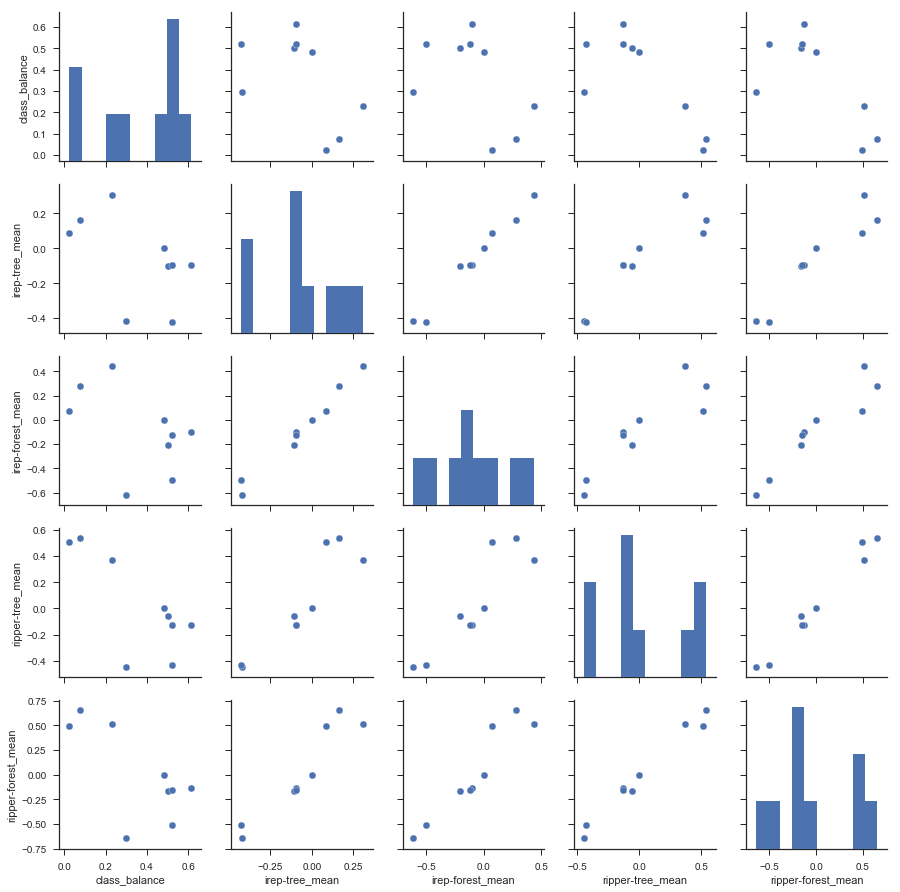

In [181]:
import seaborn as sns; 
sns.pairplot(results['recall'][['class_balance']+gain_columns]);

Overfitting: who does better with fewer examples?

In [186]:
# Precision

results['precision'][['examples']+gain_columns].sort_values('examples')

,examples,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
SPECT_train,80,0.049061,0.026879,0.049523,0.027341
breast-cancer,286,-0.191860,-0.184192,-0.131552,-0.123885
house-votes-84,435,-0.010972,-0.028268,0.026539,0.009243
depression,1020,0.096129,0.104401,0.156645,0.164917
hiv,1625,0.321342,-0.174159,0.439096,-0.056404
car_mod,1728,0.314436,-0.054413,0.285314,-0.083535
kr-vs-kp,3196,-0.143539,-0.125131,-0.009652,0.008756
mushroom,8124,-0.072281,-0.072209,-0.000705,-0.000633
nursery_mod,12960,0.344872,-0.103293,0.305134,-0.143031


In [187]:
# Recall

results['recall'][['examples']+gain_columns].sort_values('examples')

,examples,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
SPECT_train,80,-0.103818,-0.208999,-0.056708,-0.161888
breast-cancer,286,-0.417286,-0.617893,-0.444801,-0.645408
house-votes-84,435,-0.097327,-0.098751,-0.129512,-0.130937
depression,1020,-0.424175,-0.497488,-0.432675,-0.505988
hiv,1625,0.304831,0.440538,0.371984,0.507691
car_mod,1728,0.161231,0.277831,0.537496,0.654096
kr-vs-kp,3196,-0.096557,-0.122157,-0.127247,-0.152847
mushroom,8124,0.000000,0.000000,-0.000230,-0.000230
nursery_mod,12960,0.086875,0.070394,0.511476,0.494995


In [189]:
# Recall

results['precision'][['examples:feat']+gain_columns].sort_values('examples:feat')

,examples:feat,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
SPECT_train,3.636364,0.049061,0.026879,0.049523,0.027341
house-votes-84,27.187500,-0.010972,-0.028268,0.026539,0.009243
breast-cancer,31.777778,-0.191860,-0.184192,-0.131552,-0.123885
kr-vs-kp,88.777778,-0.143539,-0.125131,-0.009652,0.008756
hiv,203.125000,0.321342,-0.174159,0.439096,-0.056404
car_mod,246.857143,0.314436,-0.054413,0.285314,-0.083535
depression,340.000000,0.096129,0.104401,0.156645,0.164917
mushroom,369.272727,-0.072281,-0.072209,-0.000705,-0.000633
nursery_mod,1440.000000,0.344872,-0.103293,0.305134,-0.143031


In [190]:
results['recall'][['examples:feat']+gain_columns].sort_values('examples:feat')

,examples:feat,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
SPECT_train,3.636364,-0.103818,-0.208999,-0.056708,-0.161888
house-votes-84,27.187500,-0.097327,-0.098751,-0.129512,-0.130937
breast-cancer,31.777778,-0.417286,-0.617893,-0.444801,-0.645408
kr-vs-kp,88.777778,-0.096557,-0.122157,-0.127247,-0.152847
hiv,203.125000,0.304831,0.440538,0.371984,0.507691
car_mod,246.857143,0.161231,0.277831,0.537496,0.654096
depression,340.000000,-0.424175,-0.497488,-0.432675,-0.505988
mushroom,369.272727,0.000000,0.000000,-0.000230,-0.000230
nursery_mod,1440.000000,0.086875,0.070394,0.511476,0.494995


In [180]:
# Much more compact than Tree and Forest

results['complexity']

,features,examples,examples:feat,class_balance,irep:tree_mean,irep:forest_mean,ripper:tree_mean,ripper:forest_mean
SPECT_train,22,80,3.636364,0.500000,0.052500,0.003752,0.055000,0.004128
breast-cancer,9,286,31.777778,0.297203,0.018809,0.000793,0.028997,0.001468
car_mod,7,1728,246.857143,0.077546,0.023747,0.000772,0.115600,0.004331
depression,3,1020,340.000000,0.522549,0.165217,0.004005,0.043478,0.001335
hiv,8,1625,203.125000,0.230769,0.039461,0.001642,0.217283,0.009525
house-votes-84,16,435,27.187500,0.613793,0.077128,0.002216,0.085106,0.002363
kr-vs-kp,36,3196,88.777778,0.522215,0.100286,0.001608,0.229836,0.003836
mushroom,22,8124,369.272727,0.482029,0.238806,0.001398,1.041045,0.006502
nursery_mod,9,12960,1440.000000,0.025463,0.005643,0.003446,0.032618,0.019978


In [160]:
# Imbalanced classes (recall):

# IREP and RIPPER outperform both Tree and Forest

results['precision'].sort_values('examples:feat')

,features,examples,examples:feat,class_balance,irep-tree_mean,irep-forest_mean,ripper-tree_mean,ripper-forest_mean
SPECT_train,22,80,3.636364,0.500000,0.049061,0.026879,0.049523,0.027341
house-votes-84,16,435,27.187500,0.613793,-0.010972,-0.028268,0.026539,0.009243
breast-cancer,9,286,31.777778,0.297203,-0.191860,-0.184192,-0.131552,-0.123885
kr-vs-kp,36,3196,88.777778,0.522215,-0.143539,-0.125131,-0.009652,0.008756
hiv,8,1625,203.125000,0.230769,0.321342,-0.174159,0.439096,-0.056404
car_mod,7,1728,246.857143,0.077546,0.314436,-0.054413,0.285314,-0.083535
depression,3,1020,340.000000,0.522549,0.096129,0.104401,0.156645,0.164917
mushroom,22,8124,369.272727,0.482029,-0.072281,-0.072209,-0.000705,-0.000633
nursery_mod,9,12960,1440.000000,0.025463,0.344872,-0.103293,0.305134,-0.143031


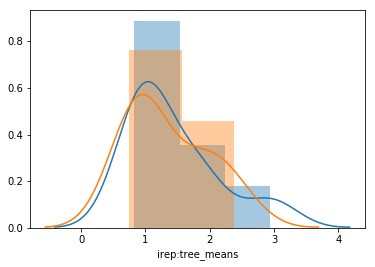

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.hist(results['precision']['irep:tree_meds'])
#plt.xmin = 0
#plt.xmax = 3
#plt.subplot(2, 1, 1)

#plt.hist(results['precision']['ripper:tree_means'])
#plt.hist(results['recall']['ripper:tree_meds'])
# set palette 
#palette = sns.color_palette("cubehelix")
sns.distplot(results['precision']['ripper:tree_means'])#, kde=False)
sns.distplot(results['precision']['irep:tree_means'])#, kde=False);

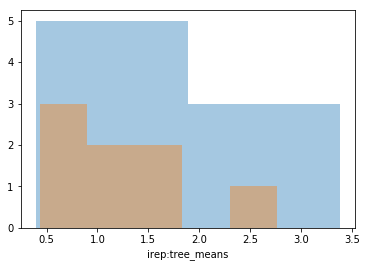

In [105]:
sns.distplot(results['recall']['ripper:tree_means'], kde=False)
sns.distplot(results['recall']['irep:tree_means'], kde=False);

In [ ]:
sns.distplot(results['recall']['ripper:tree_means'], kde=False)
sns.distplot(results['recall']['irep:tree_means'], kde=False);

In [ ]:
a
measurement=[]
irep_means=[]
irep_meds=[]
ripper_means=[]
ripper_meds=[]
tree_means=[]
tree_meds=[]
for col in columns:
    feat[col] = []

results_files = [f for f in os.listdir(datasets_path) if 'pkl' in f] 
for f in results_files:
    result = pickle.load(open(datasets_path+f, "rb"))
    print(result)
    break